In [1]:
#Loading All Needed Libraries

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# #Number Manupulation & Plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# #Model Selection Libraries
# from sklearn import model_selection
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import validation_curve

# #Preprocessing Libraries
# from sklearn.preprocessing import scale
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures

# #Liner Model Libraries
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet

# #pipeline libraries
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline

# #Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# import sklearn
# import sklearn.decomposition

# from sklearn.svm import SVC
# from sklearn.feature_selection import RFE

# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor

from google.colab import drive
drive.mount('/content/drive')
folder= "/content/drive/My Drive/Colab Notebooks/Datasets-Kaggle/"
#folder=""
file1 = folder + "telecom_churn_data.csv"
file2 = folder + "cleandata.csv"

In [ ]:
#Lad partial dataset in memory
df = pd.read_csv("telecom_churn_data.csv")

<font color=red size=6> Define Objective </font>

- Identify Hight Value Customer-HVC: Those who have recharged with an amount >= X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)

- Identify which customers are in action phase. 3rd month usage==0
- Identify which customers are churn. 3rd month + 4th month usage==0
- Make a model to predict churn from of HVC. But use only 3 month data.
- Compare the performance of model 

1. It is a regression problem
- Make a model which has highest R-square score on test dataset. 
- At the same time R-Score score on Train dataset should be such that it can be confidently accepted by the customer

<font color=red size=6> Understanding Dataset</font>

In [2]:
#A field will be treated as categorical if Max Categories are less than number below.
#This is just a guess and it can be tuned. It is just to ease the data cleaning process and has no other value.
max_cat=200

In [3]:
target_="churn"
id_="mobile_number"

In [5]:
#Create a list of Categorical Variables. This step is useful when there are many fields in dataset
#If they are numeric in nature, convert into Object
#In final dataset all categorical variable (ordinal, nominal) will be object type

In [4]:
#Returns a list of field of particular type from dataset=df, 
#fldType : cat for categorical variables, num for numerial variables
#the return list will not include target variable name and id variable name.

def get_fld_list(df, fldType, printResults=False):
    categories = min(max_cat, int(len(df)*.5))
    fld_list = []
    for col in df.columns:
        l=len(df[col].unique())
        if fldType=="cat":
            if l<=categories:
                fld_list.append(col)
                if printResults:
                    print ("Categorical Field:",col, df[col].unique())
            else:
                if printResults:
                    print ("Excluded Fields",col,l)  
                    
        elif fldType=="bin":
            if l==2:
                fld_list.append(col)
                if printResults:
                    print ("Binary Field:",col, df[col].unique())
            else:
                if printResults:
                    print ("Excluded Fields",col,l)  
        
        elif fldType=="num":
            if l>categories:
                if l>categories:
                    fld_list.append(col)
                else:
                    if printResults:
                        print (col,l)
                
    if target_ in fld_list:
        fld_list.remove(target_)
    if id_ in fld_list:
        fld_list.remove(id_)
        
    fld_list.sort()
    return fld_list

<font color=red size=3>Understanding Field Name & Renaming them for correct standard use</font>

In [8]:
#identify those columns which has date information
all_cols= df.columns
cols_date = [c for c in all_cols if 'date_' in c]
cols_date

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [9]:
df[cols_date].head(2)

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
0            9/30/2014           6/21/2014           7/16/2014   
1            9/30/2014           6/29/2014           7/31/2014   

  date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
0            8/8/2014           9/28/2014                6/21/2014   
1           8/28/2014           9/30/2014                      NaN   

  date_of_last_rech_data_7 date_of_last_rech_data_8 date_of_last_rech_data_9  
0                7/16/2014                 8/8/2014                      NaN  
1                7/25/2014                8/10/2014                      NaN

In [10]:
#Check what dates are stored
for c in cols_date:
    print ( df[c].astype("category").value_counts())

6/30/2014    99999
Name: last_date_of_month_6, dtype: int64
7/31/2014    99398
Name: last_date_of_month_7, dtype: int64
8/31/2014    98899
Name: last_date_of_month_8, dtype: int64
9/30/2014    98340
Name: last_date_of_month_9, dtype: int64
6/30/2014    16960
6/29/2014    12918
6/27/2014    11169
6/28/2014     9491
6/26/2014     5530
6/25/2014     4896
6/17/2014     4145
6/24/2014     4129
6/14/2014     3845
6/21/2014     3747
6/23/2014     2908
6/18/2014     2747
6/12/2014     2511
6/22/2014     2344
6/13/2014     2147
6/19/2014     2009
6/20/2014     1803
6/16/2014     1126
6/15/2014      873
6/11/2014      579
6/8/2014       520
6/5/2014       327
6/7/2014       322
6/10/2014      283
6/3/2014       233
6/1/2014       218
6/9/2014       199
6/6/2014       173
6/4/2014       131
6/2/2014       109
Name: date_of_last_rech_6, dtype: int64
7/31/2014    17288
7/30/2014    13863
7/25/2014     9401
7/29/2014     9052
7/28/2014     7502
7/27/2014     5909
7/26/2014     5382
7/24/2014     399

In [11]:
#Delete following columns because there is only one date in these column and it will not help in prediction.
df.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'],inplace=True)

In [12]:
all_cols= df.columns
cols_date = [c for c in all_cols if 'date_' in c]
df[cols_date].head(2)

last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
0            9/30/2014           6/21/2014           7/16/2014   
1            9/30/2014           6/29/2014           7/31/2014   

  date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
0            8/8/2014           9/28/2014                6/21/2014   
1           8/28/2014           9/30/2014                      NaN   

  date_of_last_rech_data_7 date_of_last_rech_data_8 date_of_last_rech_data_9  
0                7/16/2014                 8/8/2014                      NaN  
1                7/25/2014                8/10/2014                      NaN

In [13]:
#extract day of the date from date column and remove month and year information. That is not useful for us.
from datetime import datetime
for col in cols_date:
    df[col] = df[col].str.split("/",expand=True)[1]
    df[col] = df[col].astype("float16")

In [14]:
df[cols_date].head(3)

last_date_of_month_9  date_of_last_rech_6  date_of_last_rech_7  \
0                  30.0                 21.0                 16.0   
1                  30.0                 29.0                 31.0   
2                  30.0                 17.0                 24.0   

   date_of_last_rech_8  date_of_last_rech_9  date_of_last_rech_data_6  \
0                  8.0                 28.0                      21.0   
1                 28.0                 30.0                       NaN   
2                 14.0                 29.0                       NaN   

   date_of_last_rech_data_7  date_of_last_rech_data_8  \
0                      16.0                       8.0   
1                      25.0                      10.0   
2                       NaN                       NaN   

   date_of_last_rech_data_9  
0                       NaN  
1                       NaN  
2                      17.0

In [15]:
#Get a list of categorical column. A columns which has 31 unique values in column is categorical column. 
#It is based on my observation about the dataset.
cols_all_cat = get_fld_list(df,"cat", printResults=False)

In [16]:
#Get a list of Numerical column. A columns which has more than 31 unique values in column is numerical column.
#It is based on my observation about the dataset.
cols_all_num = get_fld_list(df, "num", printResults=False)

In [17]:
df[cols_all_cat].head(2)

circle_id  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0        109              0.0              0.0              0.0   
1        109              NaN              1.0              2.0   

   count_rech_2g_9  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  \
0              NaN              1.0              1.0              1.0   
1              NaN              NaN              0.0              0.0   

   count_rech_3g_9  date_of_last_rech_6        ...         std_og_t2c_mou_9  \
0              NaN                 21.0        ...                      NaN   
1              NaN                 29.0        ...                      0.0   

   std_og_t2o_mou  total_rech_data_6  total_rech_data_7  total_rech_data_8  \
0             0.0                1.0                1.0                1.0   
1             0.0                NaN                1.0                2.0   

   total_rech_data_9  total_rech_num_6  total_rech_num_7  total_rech_num_8  \
0                NaN                 4                 3                 2   
1                NaN                 4                 9                11   

   total_rech_num_9  
0                 6  
1                 5  

[2 rows x 74 columns]

In [18]:
df[cols_all_num].head(2)

aon  arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_2g_9  arpu_3g_6  arpu_3g_7  \
0   968     212.17     212.17     212.17        NaN     212.17     212.17   
1  1006        NaN      28.61       7.60        NaN        NaN       0.00   

   arpu_3g_8  arpu_3g_9   arpu_6     ...       total_rech_amt_8  \
0     212.17        NaN  197.385     ...                    252   
1       0.00        NaN   34.047     ...                    283   

   total_rech_amt_9  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_2g_mb_9  \
0                 0        30.13         1.32         5.75          0.0   
1               121         0.00       108.07       365.47          0.0   

   vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_3g_mb_9  
0        83.57       150.76       109.61          0.0  
1         0.00         0.00         0.00          0.0  

[2 rows x 148 columns]

<font color=red size=6>Check Null Values</fond>

In [19]:
#% of null values in all types of Fields
temp=(df.isnull().sum()/len(df)*100).sort_values()[::-1]
temp[temp>0]

date_of_last_rech_data_6    74.846748
night_pck_user_6            74.846748
count_rech_2g_6             74.846748
count_rech_3g_6             74.846748
av_rech_amt_data_6          74.846748
total_rech_data_6           74.846748
arpu_3g_6                   74.846748
arpu_2g_6                   74.846748
max_rech_data_6             74.846748
fb_user_6                   74.846748
arpu_3g_7                   74.428744
max_rech_data_7             74.428744
count_rech_2g_7             74.428744
fb_user_7                   74.428744
arpu_2g_7                   74.428744
count_rech_3g_7             74.428744
av_rech_amt_data_7          74.428744
date_of_last_rech_data_7    74.428744
night_pck_user_7            74.428744
total_rech_data_7           74.428744
fb_user_9                   74.077741
date_of_last_rech_data_9    74.077741
arpu_3g_9                   74.077741
total_rech_data_9           74.077741
arpu_2g_9                   74.077741
av_rech_amt_data_9          74.077741
night_pck_us

In [20]:
##% of Null value in Categorical Fields
temp=(df[cols_all_cat].isnull().sum() /len(df)*100).sort_values()[::-1]
temp[temp>0]

count_rech_3g_6             74.846748
max_rech_data_6             74.846748
count_rech_2g_6             74.846748
total_rech_data_6           74.846748
fb_user_6                   74.846748
date_of_last_rech_data_6    74.846748
night_pck_user_6            74.846748
count_rech_2g_7             74.428744
count_rech_3g_7             74.428744
fb_user_7                   74.428744
total_rech_data_7           74.428744
max_rech_data_7             74.428744
date_of_last_rech_data_7    74.428744
night_pck_user_7            74.428744
count_rech_3g_9             74.077741
night_pck_user_9            74.077741
max_rech_data_9             74.077741
date_of_last_rech_data_9    74.077741
count_rech_2g_9             74.077741
total_rech_data_9           74.077741
fb_user_9                   74.077741
max_rech_data_8             73.660737
night_pck_user_8            73.660737
total_rech_data_8           73.660737
count_rech_3g_8             73.660737
fb_user_8                   73.660737
date_of_last

In [21]:
##Null Value percentage for numeric fields
temp= (df[cols_all_num].isnull().sum() /len(df)*100).sort_values()[::-1]
df_num =temp[temp>0]
df_num

arpu_2g_6             74.846748
av_rech_amt_data_6    74.846748
arpu_3g_6             74.846748
arpu_3g_7             74.428744
arpu_2g_7             74.428744
av_rech_amt_data_7    74.428744
arpu_3g_9             74.077741
av_rech_amt_data_9    74.077741
arpu_2g_9             74.077741
arpu_3g_8             73.660737
arpu_2g_8             73.660737
av_rech_amt_data_8    73.660737
std_ic_t2f_mou_9       7.745077
loc_ic_t2f_mou_9       7.745077
loc_ic_mou_9           7.745077
ic_others_9            7.745077
std_og_mou_9           7.745077
offnet_mou_9           7.745077
std_ic_mou_9           7.745077
og_others_9            7.745077
std_ic_t2t_mou_9       7.745077
loc_og_t2t_mou_9       7.745077
roam_ic_mou_9          7.745077
onnet_mou_9            7.745077
std_ic_t2m_mou_9       7.745077
std_og_t2f_mou_9       7.745077
loc_og_t2f_mou_9       7.745077
spl_og_mou_9           7.745077
loc_ic_t2t_mou_9       7.745077
std_og_t2m_mou_9       7.745077
                        ...    
loc_ic_t

In [22]:
##check what kind of values are stored in catorical fields
#cats = ((df[cols_all_cat].isnull().sum() /len(df)*100).sort_values()[::-1]>0).index
for i in cols_all_cat:
    print ( df[i].astype("object").value_counts() , "\n=====================================")

109    99999
Name: circle_id, dtype: int64 
1.0     10902
0.0      5920
2.0      3240
3.0      1461
4.0       984
5.0       635
6.0       477
7.0       361
8.0       287
9.0       238
10.0      196
11.0      125
12.0      111
13.0       51
14.0       46
15.0       27
17.0       19
16.0       16
18.0       13
19.0       12
20.0        7
22.0        7
21.0        5
24.0        3
25.0        3
28.0        2
39.0        1
30.0        1
32.0        1
34.0        1
42.0        1
Name: count_rech_2g_6, dtype: int64 
1.0     10495
0.0      5798
2.0      3377
3.0      1489
4.0      1121
5.0       848
6.0       622
7.0       437
8.0       369
10.0      248
9.0       214
11.0      159
12.0      133
13.0       56
14.0       54
15.0       32
16.0       29
18.0       19
17.0       13
19.0       13
20.0       11
23.0        6
21.0        5
22.0        5
26.0        3
27.0        3
24.0        2
32.0        2
30.0        1
35.0        1
31.0        1
43.0        1
29.0        1
28.0        1
25.0     

154.0     4900
25.0      4402
252.0     3144
98.0      1441
198.0     1380
17.0      1274
23.0      1098
145.0     1062
152.0      908
14.0       669
41.0       530
179.0      517
91.0       512
46.0       418
149.0      328
177.0      315
56.0       301
274.0      301
49.0       280
455.0      197
33.0       176
125.0      170
8.0        163
202.0      145
655.0       96
505.0       74
449.0       61
1.0         45
29.0        39
101.0       31
755.0       30
951.0       27
5.0         21
22.0        18
52.0        15
13.0        14
855.0       12
1555.0       9
48.0         6
15.0         5
9.0          5
61.0         4
295.0        3
1255.0       3
495.0        1
148.0        1
995.0        1
1505.0       1
Name: max_rech_data_6, dtype: int64 
154.0     4915
25.0      4444
252.0     3225
198.0     1585
17.0      1559
98.0      1488
23.0      1216
145.0      952
152.0      865
179.0      572
46.0       525
41.0       492
91.0       473
14.0       360
274.0      328
149.0      317
56.

0.00     85588
0.20      1254
0.18       773
0.06       481
0.05       455
0.08       412
0.40       369
0.11       351
0.10       322
0.36       302
0.13       292
0.16       269
0.31       232
0.26       219
0.23       212
0.38       207
0.03       206
0.15       200
0.28       196
0.33       185
0.60       163
0.21       161
0.24       147
0.29       133
0.54       132
0.46       122
0.41       118
0.43       113
0.53       104
0.51       103
         ...  
1.08         9
0.94         9
1.09         9
0.98         9
1.01         7
0.85         7
0.04         7
1.13         6
1.03         6
1.06         5
0.99         4
1.10         4
1.15         4
1.04         3
1.18         3
1.14         2
2.96         2
13.46        1
6.43         1
7.00         1
5.24         1
21.33        1
1.50         1
2.00         1
5.88         1
1.28         1
1.58         1
2.91         1
1.16         1
12.34        1
Name: spl_ic_mou_7, Length: 107, dtype: int64 
0.00     82923
0.25      1525
0.50    

In [23]:
#These columns has only one value in the columns so no use for modeling
df.drop(columns = ['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','last_date_of_month_9',
'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9','std_ic_t2o_mou_6',
'std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_t2o_mou_9'],inplace=True)

<font color=red size=6>Imputing Null Values</font>

<font color=red size=3>__Convert categorical variables into number__</font>

We need to convert values in categorical variables in number for following reasons.
1. So that we can check relation between categorical variable and sales price. 
- So that we can do Categorical Field's null value imputation using K Neighbour Mean. 
- So that we can do the modeling 

<font color=red size=3>__Impute Numeric Value Fields__</font>

In [24]:
cols_all_num =get_fld_list(df,"num",False)
df[cols_all_num].head(5)

aon  arpu_2g_6  arpu_2g_7  arpu_2g_8  arpu_2g_9  arpu_3g_6  arpu_3g_7  \
0   968     212.17     212.17     212.17        NaN     212.17     212.17   
1  1006        NaN      28.61       7.60        NaN        NaN       0.00   
2  1103        NaN        NaN        NaN        0.0        NaN        NaN   
3  2491        NaN        NaN        NaN        NaN        NaN        NaN   
4  1526       0.00        NaN        NaN        NaN       0.00        NaN   

   arpu_3g_8  arpu_3g_9   arpu_6     ...       total_rech_amt_8  \
0     212.17        NaN  197.385     ...                    252   
1       0.00        NaN   34.047     ...                    283   
2        NaN       2.84  167.690     ...                    116   
3        NaN        NaN  221.338     ...                    601   
4        NaN        NaN  261.636     ...                    287   

   total_rech_amt_9  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_2g_mb_9  \
0                 0        30.13         1.32         5.75          0.0   
1               121         0.00       108.07       365.47          0.0   
2               358         0.00         0.00         0.00          0.0   
3               410         0.00         0.00         0.00          0.0   
4               200         0.00         0.00         0.00          0.0   

   vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_3g_mb_9  
0        83.57       150.76       109.61         0.00  
1         0.00         0.00         0.00         0.00  
2         0.00         0.00         0.00         8.42  
3         0.00         0.00         0.00         0.00  
4         0.00         0.00         0.00         0.00  

[5 rows x 148 columns]

In [25]:
#Impute Numeric Null Values Columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
df_filled = imputer.fit_transform( df )
df_filled = pd.DataFrame(df_filled, columns=df.columns, index= df.index)

In [26]:
#in above steps categorical fields also got imputed. Because Iterative Imputer uses Linear Regression for imputation
#I don't want decimal number in imputed filed so reverting back those imputation.
df[cols_all_num] = df_filled[cols_all_num]

In [27]:
df[cols_all_num].head(5)

aon   arpu_2g_6   arpu_2g_7   arpu_2g_8  arpu_2g_9   arpu_3g_6  \
0   968.0  212.170000  212.170000  212.170000  54.928371  212.170000   
1  1006.0   61.745531   28.610000    7.600000  57.511972   24.863418   
2  1103.0   71.592648   46.862648   52.157294   0.000000   68.516158   
3  2491.0   54.128276   61.440025   74.758306  66.851136   27.689201   
4  1526.0    0.000000   55.557194   54.324187  61.877959    0.000000   

    arpu_3g_7   arpu_3g_8  arpu_3g_9   arpu_6     ...       total_rech_amt_8  \
0  212.170000  212.170000  10.658599  197.385     ...                  252.0   
1    0.000000    0.000000   6.011980   34.047     ...                  283.0   
2  -30.347836   37.040376   2.840000  167.690     ...                  116.0   
3   32.238325   67.406176  54.303385  221.338     ...                  601.0   
4   46.047581   41.149675  35.747487  261.636     ...                  287.0   

   total_rech_amt_9  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8  vol_2g_mb_9  \
0               0.0        30.13         1.32         5.75          0.0   
1             121.0         0.00       108.07       365.47          0.0   
2             358.0         0.00         0.00         0.00          0.0   
3             410.0         0.00         0.00         0.00          0.0   
4             200.0         0.00         0.00         0.00          0.0   

   vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_3g_mb_9  
0        83.57       150.76       109.61         0.00  
1         0.00         0.00         0.00         0.00  
2         0.00         0.00         0.00         8.42  
3         0.00         0.00         0.00         0.00  
4         0.00         0.00         0.00         0.00  

[5 rows x 148 columns]

<font color=red size=3>__Impute Categorical Value Fields__</font>

In [28]:
cols_all_cat =get_fld_list(df,"cat",False)
df[cols_all_cat].head()

count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_2g_9  \
0              0.0              0.0              0.0              NaN   
1              NaN              1.0              2.0              NaN   
2              NaN              NaN              NaN              1.0   
3              NaN              NaN              NaN              NaN   
4              1.0              NaN              NaN              NaN   

   count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  count_rech_3g_9  \
0              1.0              1.0              1.0              NaN   
1              NaN              0.0              0.0              NaN   
2              NaN              NaN              NaN              0.0   
3              NaN              NaN              NaN              NaN   
4              0.0              NaN              NaN              NaN   

   date_of_last_rech_6  date_of_last_rech_7        ...         spl_ic_mou_7  \
0                 21.0                 16.0        ...                  NaN   
1                 29.0                 31.0        ...                  0.0   
2                 17.0                 24.0        ...                  0.0   
3                 28.0                 31.0        ...                  0.0   
4                 26.0                 28.0        ...                  0.0   

   spl_ic_mou_8  total_rech_data_6  total_rech_data_7  total_rech_data_8  \
0           0.0                1.0                1.0                1.0   
1           0.0                NaN                1.0                2.0   
2           0.0                NaN                NaN                NaN   
3           0.0                NaN                NaN                NaN   
4           0.0                1.0                NaN                NaN   

   total_rech_data_9  total_rech_num_6  total_rech_num_7  total_rech_num_8  \
0                NaN                 4                 3                 2   
1                NaN                 4                 9                11   
2                1.0                 5                 4                 2   
3                NaN                10                11                18   
4                NaN                 5                 6                 3   

   total_rech_num_9  
0                 6  
1                 5  
2                 7  
3                14  
4                 4  

[5 rows x 61 columns]

In [5]:
#Impute Null Categorical Values
#Imputation will be done using non_null cols
def imputeNull_CatValues(df,fld):
 
    X_test = df[NonNullVal_cols]

    cols=NonNullVal_cols.copy()
    if fld not in cols:
        cols.append(fld)


    #training using none-null columns
    df_train = df [cols] [ df[fld].notna()] 

    #supplied fld in dataframe need to be classified. So we need to train using this field
    y_train= df_train[fld]
    X_train = df_train.drop(columns=fld)
    clusters = len(y_train.unique() )

    from sklearn.neighbors import KNeighborsClassifier
    km = KNeighborsClassifier(n_neighbors=clusters)

    #t= X_train.isna().sum(axis=0)>=0
    #print ( X_train.loc[ ::,t ])
    #print (y_train.isna().sum())

    km.fit(X_train,y_train.astype(int))
    pred_train_clusterid = km.predict(X_train)
    pred_test_clusterid = km.predict(X_test)

    print (fld,"Accuracy on Train Dataset :",
    round(metrics.accuracy_score(y_train.astype(int), pred_train_clusterid),2))
    print ("==========================================")

    df1 = pd.DataFrame( {"prediction":pred_test_clusterid, "actual":df[fld]})

    #create a need field in temp dataframe df1, 
    #for a given field if actual==0 (it has null value) then use prediction to replace
    df1.loc[ df1["actual"].isna(),fld] = df1["prediction"]

    #If actual is not null then we should not use predicted cluster value, so use actual value
    df1.loc[ ~df1["actual"].isna(),fld] = df1["actual"]

    return (df1[fld])

In [30]:
## This steps impute null values only in Categorical Fields
#get list of non-null-value fields. These fields will be used for creating cluster and imputation using KNeighborsClassifier
temp =df.isna().sum()
NonNullVal_cols = list(temp[ temp==0].index)

### WARNING :- Step below is taking too much time on my machine.
If you do not have enough time then you can jump to section "Reading from from cleandata" and uncomment the line. Following that process can be resume without wasting much time.

In [31]:
for colname in cols_all_cat: #Get catgorical variable
    if colname not in NonNullVal_cols: #Dont impute if the cat variable in Non-Null columns
        print (colname)
        df[colname] = imputeNull_CatValues(df,colname)

count_rech_2g_6
count_rech_2g_6 Accuracy on Train Dataset : 0.46
count_rech_2g_7
count_rech_2g_7 Accuracy on Train Dataset : 0.44
count_rech_2g_8
count_rech_2g_8 Accuracy on Train Dataset : 0.45
count_rech_2g_9
count_rech_2g_9 Accuracy on Train Dataset : 0.44
count_rech_3g_6
count_rech_3g_6 Accuracy on Train Dataset : 0.64
count_rech_3g_7
count_rech_3g_7 Accuracy on Train Dataset : 0.64
count_rech_3g_8
count_rech_3g_8 Accuracy on Train Dataset : 0.64
count_rech_3g_9
count_rech_3g_9 Accuracy on Train Dataset : 0.63
date_of_last_rech_6
date_of_last_rech_6 Accuracy on Train Dataset : 0.23
date_of_last_rech_7
date_of_last_rech_7 Accuracy on Train Dataset : 0.22
date_of_last_rech_8
date_of_last_rech_8 Accuracy on Train Dataset : 0.22
date_of_last_rech_9
date_of_last_rech_9 Accuracy on Train Dataset : 0.31
date_of_last_rech_data_6
date_of_last_rech_data_6 Accuracy on Train Dataset : 0.13
date_of_last_rech_data_7
date_of_last_rech_data_7 Accuracy on Train Dataset : 0.13
date_of_last_rech_data

In [32]:
#Check any null value column
df.iloc[:, list(df.isna().sum()>0)].head(5)
#Here we see there is no row with null values.

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [33]:
#Alternatively, Check Null Value Columns
(df.isnull().sum()/len(df)*100).sort_values()[::-1]
#No columns which has any null value.

sep_vbc_3g                  0.0
std_og_t2f_mou_9            0.0
loc_ic_t2t_mou_9            0.0
loc_ic_t2t_mou_8            0.0
loc_ic_t2t_mou_7            0.0
loc_ic_t2t_mou_6            0.0
total_og_mou_9              0.0
total_og_mou_8              0.0
total_og_mou_7              0.0
total_og_mou_6              0.0
og_others_9                 0.0
og_others_8                 0.0
og_others_7                 0.0
og_others_6                 0.0
spl_og_mou_9                0.0
spl_og_mou_8                0.0
spl_og_mou_7                0.0
spl_og_mou_6                0.0
isd_og_mou_9                0.0
isd_og_mou_8                0.0
isd_og_mou_7                0.0
isd_og_mou_6                0.0
std_og_mou_9                0.0
std_og_mou_8                0.0
std_og_mou_7                0.0
loc_ic_t2m_mou_6            0.0
loc_ic_t2m_mou_7            0.0
loc_ic_t2m_mou_8            0.0
std_ic_t2t_mou_9            0.0
std_ic_mou_7                0.0
                           ... 
spl_ic_m

__Identify and Filter High Value Customers__

In [34]:
all_cols = list(df.columns)
rech_cols = [rech for rech in all_cols if "rech" in rech]

In [35]:
df[rech_cols].head().isna().sum()

total_rech_num_6            0
total_rech_num_7            0
total_rech_num_8            0
total_rech_num_9            0
total_rech_amt_6            0
total_rech_amt_7            0
total_rech_amt_8            0
total_rech_amt_9            0
max_rech_amt_6              0
max_rech_amt_7              0
max_rech_amt_8              0
max_rech_amt_9              0
date_of_last_rech_6         0
date_of_last_rech_7         0
date_of_last_rech_8         0
date_of_last_rech_9         0
date_of_last_rech_data_6    0
date_of_last_rech_data_7    0
date_of_last_rech_data_8    0
date_of_last_rech_data_9    0
total_rech_data_6           0
total_rech_data_7           0
total_rech_data_8           0
total_rech_data_9           0
max_rech_data_6             0
max_rech_data_7             0
max_rech_data_8             0
max_rech_data_9             0
count_rech_2g_6             0
count_rech_2g_7             0
count_rech_2g_8             0
count_rech_2g_9             0
count_rech_3g_6             0
count_rech

In [36]:
df[rech_cols].head(2)

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_num_9  \
0                 4                 3                 2                 6   
1                 4                 9                11                 5   

   total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_rech_amt_9  \
0             362.0             252.0             252.0               0.0   
1              74.0             384.0             283.0             121.0   

   max_rech_amt_6  max_rech_amt_7         ...          count_rech_2g_8  \
0           252.0             252         ...                      0.0   
1            44.0             154         ...                      2.0   

   count_rech_2g_9  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  \
0              1.0              1.0              1.0              1.0   
1              1.0              0.0              0.0              0.0   

   count_rech_3g_9  av_rech_amt_data_6  av_rech_amt_data_7  \
0              0.0          252.000000               252.0   
1              0.0          185.689103               154.0   

   av_rech_amt_data_8  av_rech_amt_data_9  
0               252.0          188.203171  
1                50.0          206.614386  

[2 rows x 40 columns]

In [37]:
#create a new field for first 2 month average recharge value
df['total_rech_amt_avg'] = (df['total_rech_amt_6'] + df['total_rech_amt_7' ])/2
#check 70 percentail of this field
df['total_rech_amt_avg'].describe(percentiles=[.7])

count    99999.000000
mean       325.238792
std        370.833466
min          0.000000
50%        229.000000
70%        368.500000
max      37762.500000
Name: total_rech_amt_avg, dtype: float64

In [38]:
rech_val70 = df['total_rech_amt_avg'].describe(percentiles=[.7])[5]
#keep only high value customer in dataset
df = df[ df['total_rech_amt_avg']>=rech_val70 ]

In [39]:
df.shape

(30011, 211)

__Identify Churn & Non-churn customers__

In [40]:
#Flag those customer which are churn
df['churn'] = df['total_ic_mou_9']+df['total_og_mou_9']+df['vol_2g_mb_9']+df['vol_3g_mb_9']==0
df['churn'] = df.churn.apply(lambda x: 1 if x==True else 0)
df['churn'][0:10]

7     1
8     0
13    0
16    0
17    0
21    0
24    0
33    0
38    0
41    0
Name: churn, dtype: int64

In [41]:
#correct name of columns
df[['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6', 'vbc_3g_9']] = df[['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g']]
df.drop(columns=['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g'], inplace=True)

In [42]:
#Our work of Churn identification is done so can remove those columns which contains 9th month data
all_cols=df.columns
cols_9 = [rech for rech in all_cols if "_9" in rech]
print (cols_9)
df.drop(columns=cols_9, inplace=True)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9']


In [43]:
df['churn'].astype("category").value_counts()
#churn is 8.6%

0    27418
1     2593
Name: churn, dtype: int64

#### __Saving Dataset__

In [44]:
#Above steps are very time consuming and resource consuming. 
#Once data set is cleaned and we have data what is required to create the model we need to save this
#dataset so that we can use this for remaining steps after this.
df.to_csv("cleandata.csv")

#save df in df1 so that we need not to do everything again, if dataset get wrongly manipulated in coming steps.
df1=df.copy()

### __Reading from from cleandata__

In [132]:
df=pd.read_csv("cleandata.csv")
df.drop(columns="Unnamed: 0",inplace=True)

In [133]:
df.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0     7000701601  1069.180  1349.850  3171.480        57.84        54.68   
1     7001524846   378.721   492.223   137.362       413.69       351.03   
2     7002191713   492.846   205.671   593.260       501.76       108.39   
3     7000875565   430.975   299.869   187.894        50.51        74.01   
4     7000187447   690.008    18.980    25.499      1185.91         9.28   

   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8    ...     \
0        52.29        453.43        567.16        325.91    ...      
1        35.08         94.66         80.63        136.48    ...      
2       534.24        413.31        119.28        482.46    ...      
3        70.61        296.29        229.74        162.76    ...      
4         7.79         61.64          0.00          5.54    ...      

   sachet_3g_8  fb_user_6  fb_user_7  fb_user_8     aon  total_rech_amt_avg  \
0            0        1.0        1.0        1.0   802.0              1185.0   
1            0        1.0        1.0        1.0   315.0               519.0   
2            0        0.0        0.0        1.0  2607.0               380.0   
3            0        0.0        0.0        0.0   511.0               459.0   
4            0        0.0        1.0        1.0   667.0               408.0   

   churn  vbc_3g_8  vbc_3g_7  vbc_3g_6  
0      1     57.74     19.38     18.74  
1      0     21.03    910.65    122.16  
2      0      0.00      0.00      0.00  
3      0      0.00      2.45     21.89  
4      0      0.00      0.00      0.00  

[5 rows x 160 columns]

In [134]:
df[['arpu_6','arpu_7','arpu_8']][ df.churn == 1].sum().sum()

3817653.830000001

In [135]:
df[['arpu_6','arpu_7','arpu_8']][ df.churn == 0].sum().sum()

47539488.12000009

In [141]:
print ("revenue from churn % revenue: ", 
       df[['arpu_6','arpu_7','arpu_8']][ df.churn == 1].sum().sum() / df[['arpu_6','arpu_7','arpu_8']].sum().sum()*100)
print ("churn customer percentage:", len(df['churn'][ df.churn == 1])/len(df)*100)

revenue from churn % revenue:  7.4335402731654625
churn customer percentage: 8.64016527273333


<font color=red size=6>Check Data Imbalance</font>

<font color=red size=5> Target Variable Data Imbalance</font>

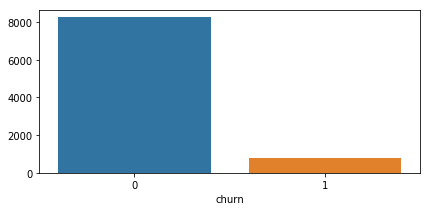

In [46]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.barplot(x=df[target_], y=df.index, estimator=len)
plt.show()

<font color=red size=5> Categorical Variable Data Imbalance</fond>

['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'og_others_7', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8']


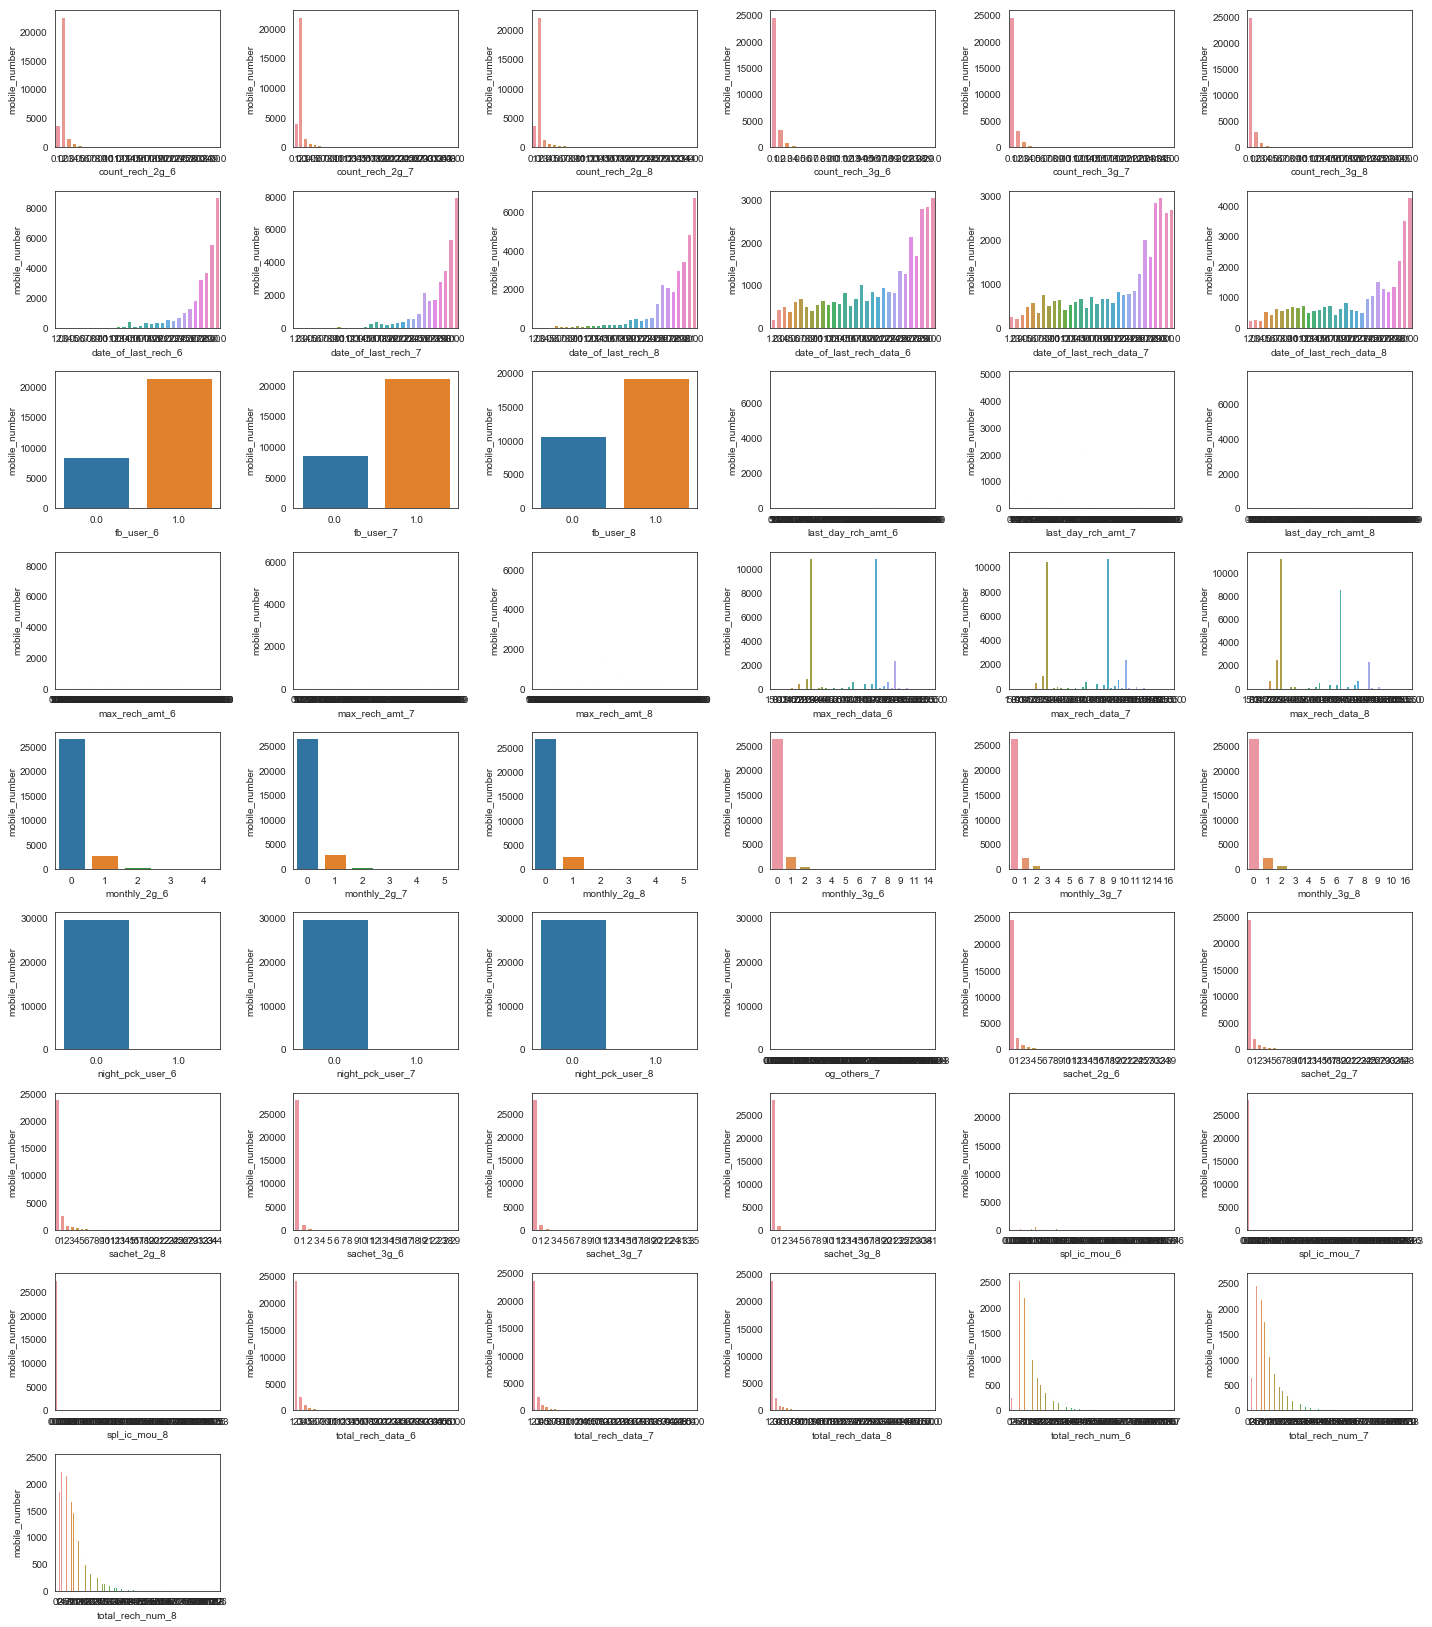

In [47]:
cols_all_cat = get_fld_list(df,"cat",False)
print (cols_all_cat)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_cat):
    plt.subplot(40,6,i)
    sns.barplot(y=id_, x=cols_all_cat[i-1], data=df, ci=0, estimator=len)
    i+=1
plt.tight_layout()

<font color=red size=5> Numerical Variable Data Distribution</font>

['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_6', 'arpu_7', 'arpu_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'og_others_6', 'og_others_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roa

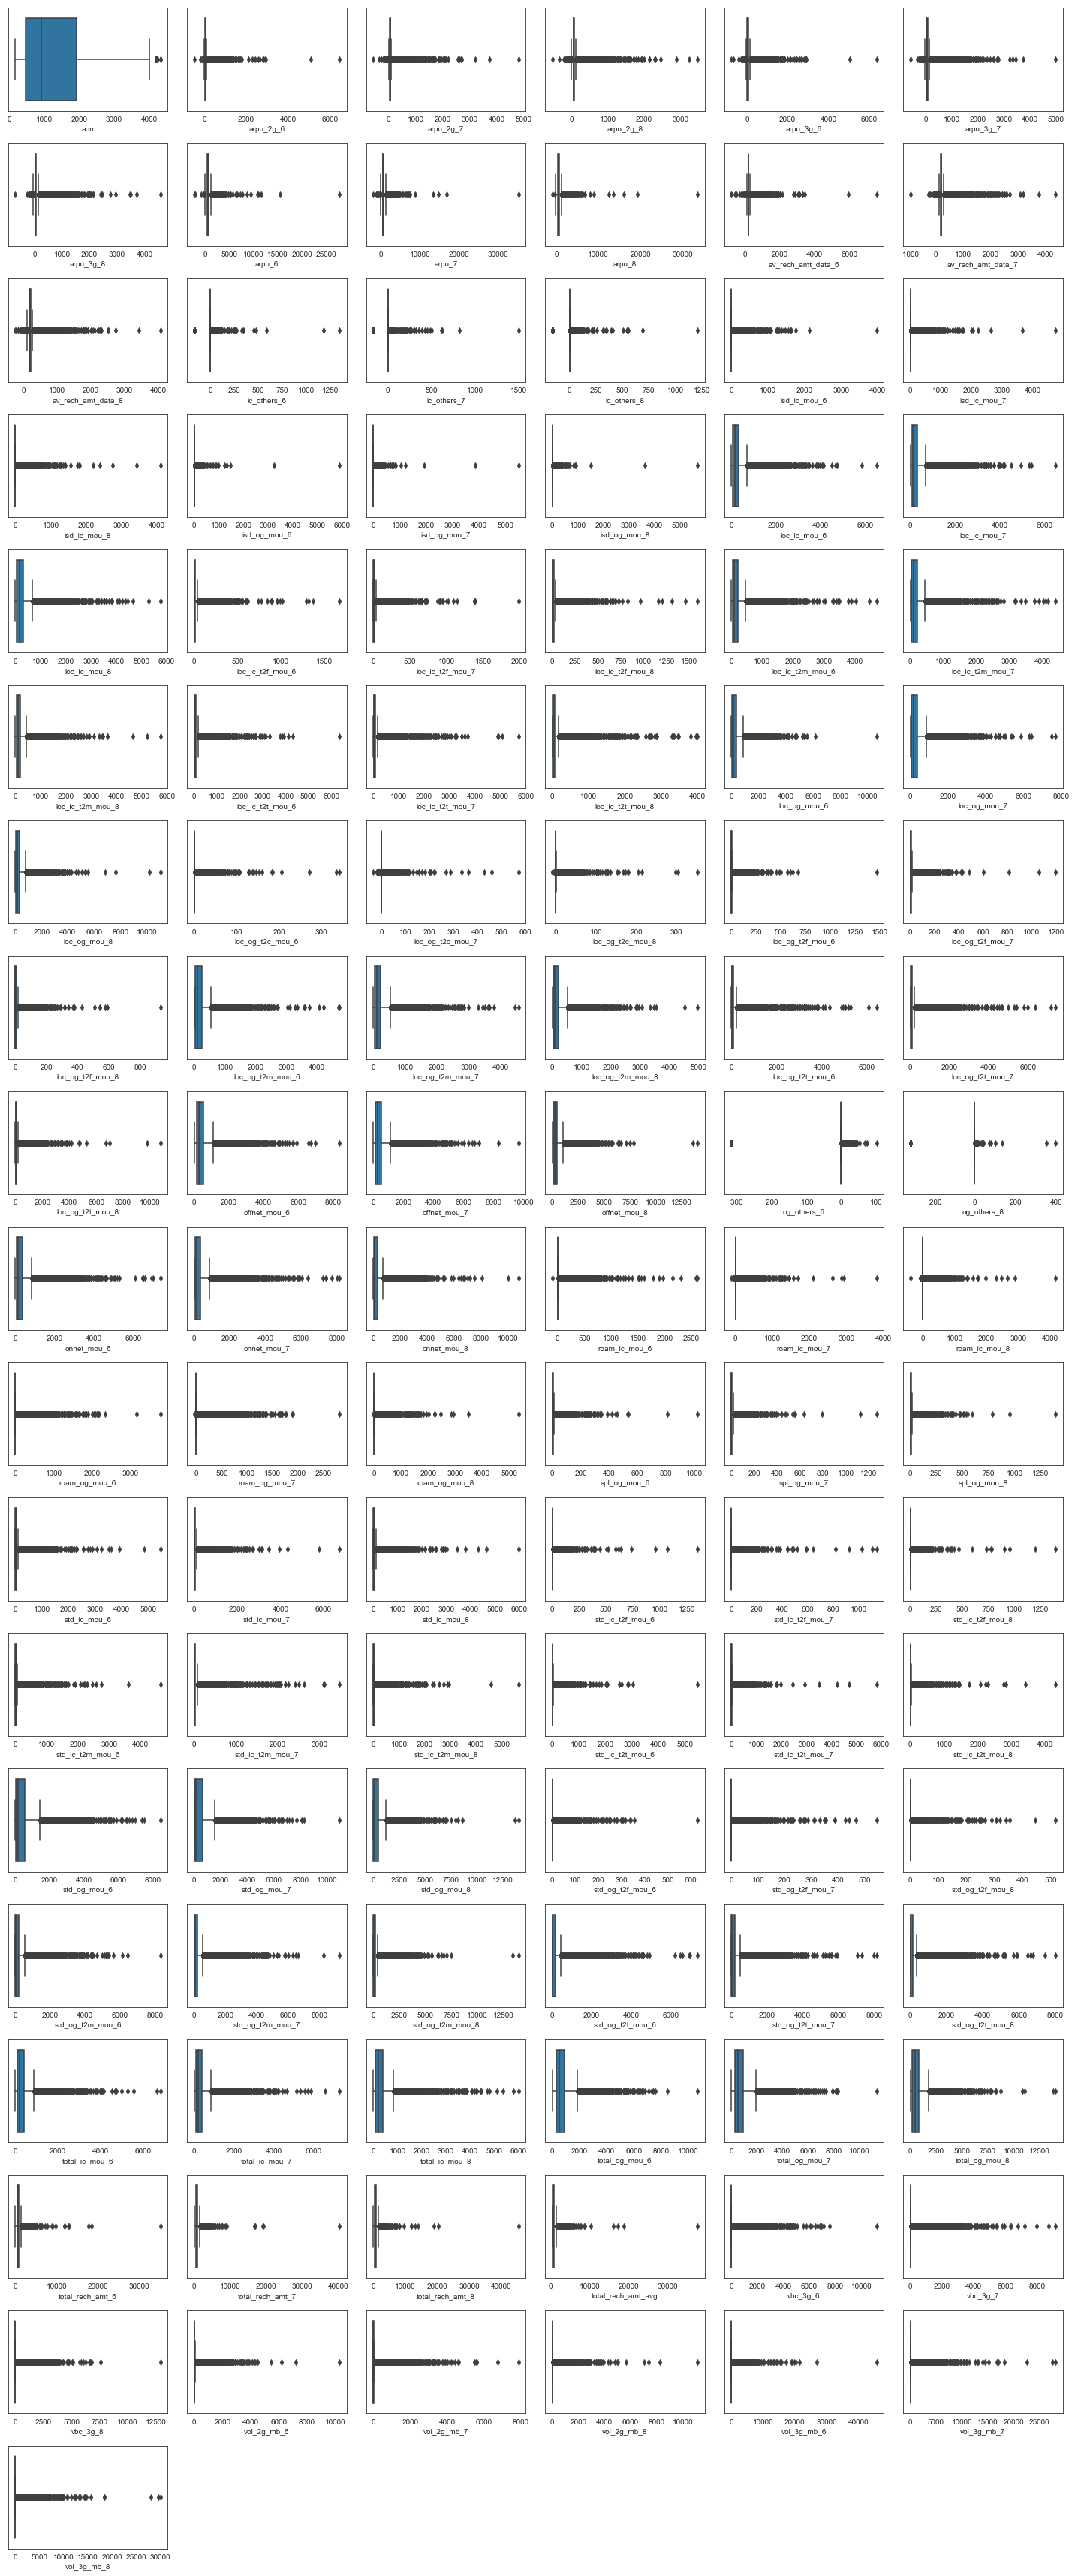

In [48]:
cols_all_num = get_fld_list(df,"num",False)
print (cols_all_num)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_num):
    plt.subplot(40,6,i)
    sns.boxplot( x=df[ cols_all_num[i-1] ])
    i+=1
plt.tight_layout()
plt.show()

<font color=red size=3> Feature Engigneering</font>

In [ ]:
#I am not feeling need of any feature engineering. I am going to convert all the variables in categorical.

<font color=red size=3> Check Distribution Now</font>

In [ ]:
#Not required

<font color=red size=6>__Check y & X Relationship__</font>

<font color=red size=3>__Check y & Cateorical Variable Relationship__</font>

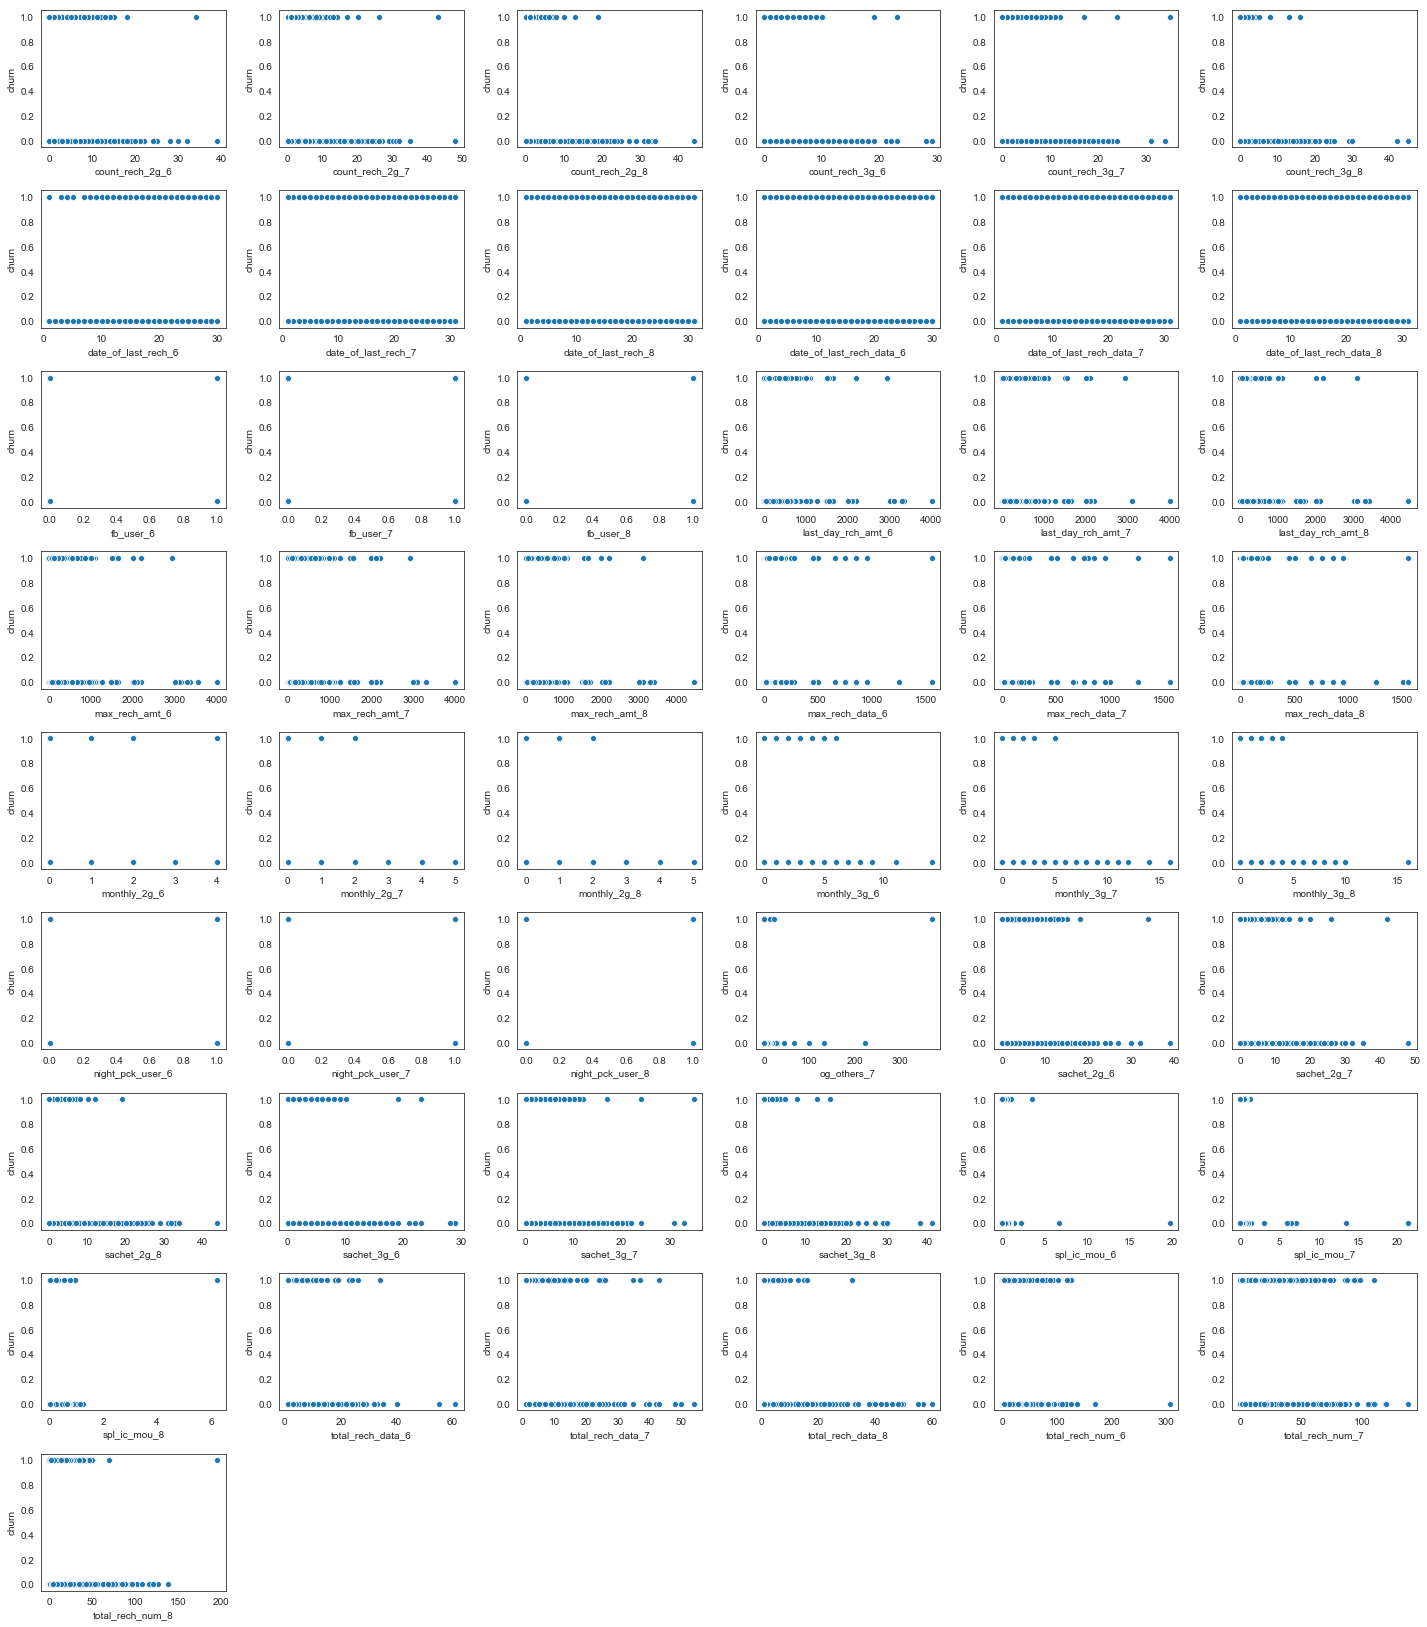

In [49]:
cols_all_cat = get_fld_list(df,"cat",False)
#print (cols_all_cat)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_cat):
    plt.subplot(40,6,i)
    sns.scatterplot(y=df[target_], x=cols_all_cat[i-1], data=df)
    i+=1
plt.tight_layout()

<font color=red size=3>__Check y & Numeric Variable Relationship__</font>

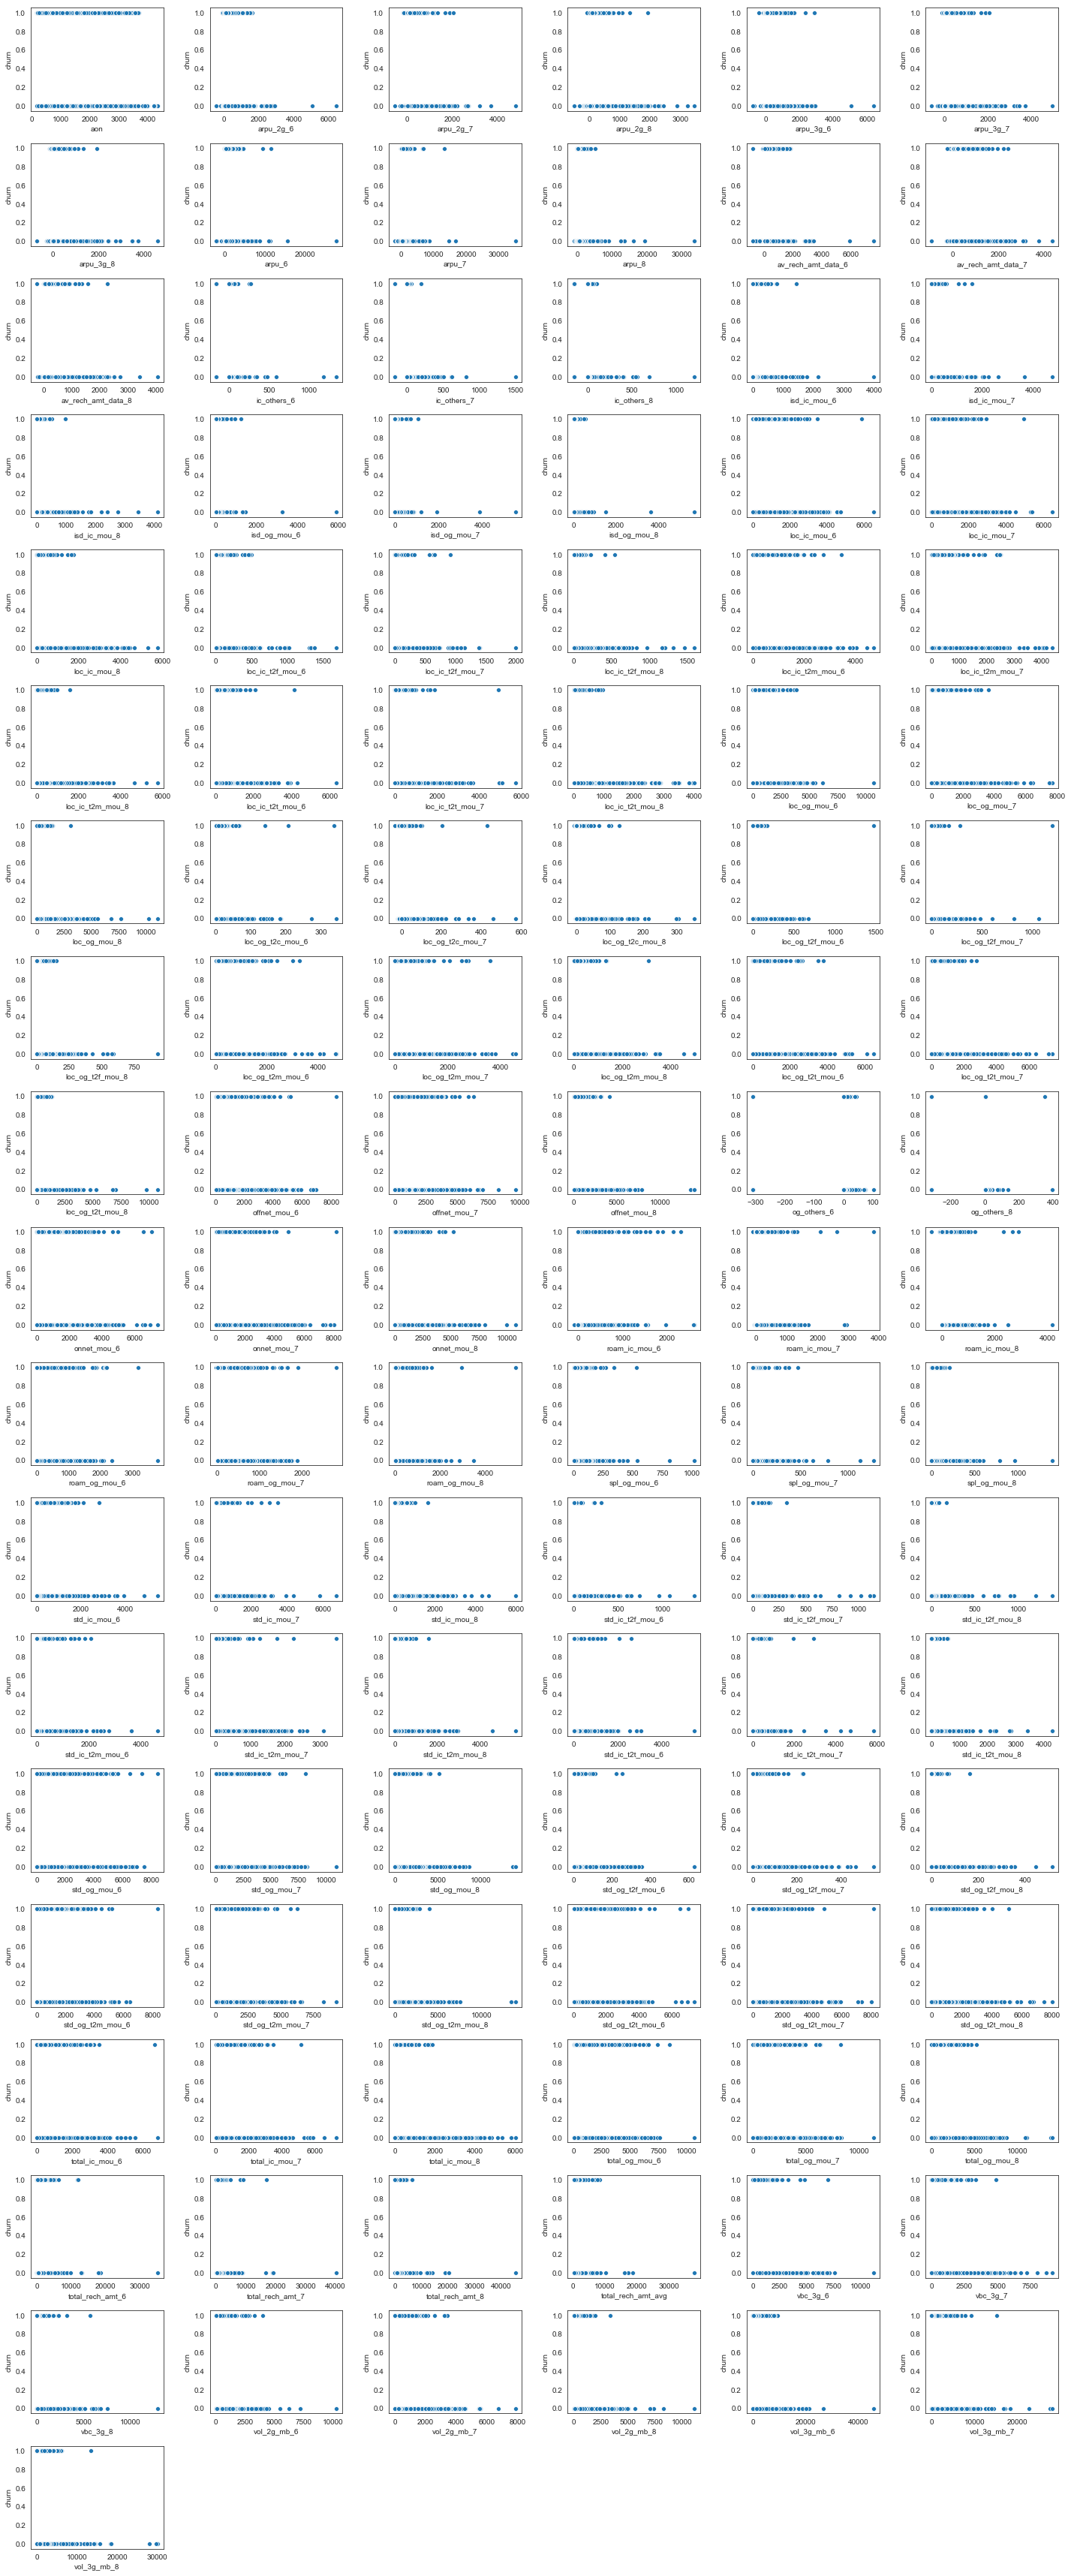

In [50]:
cols_all_num = get_fld_list(df,"num",False)
#print (cols_all_num)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_all_num):
    plt.subplot(40,6,i)
    sns.scatterplot(y=df[target_], x=cols_all_num[i-1], data=df)
    i+=1
plt.tight_layout()


<font color=red size=3> Check Degree of Correlation between y & Numeric Variable</font>

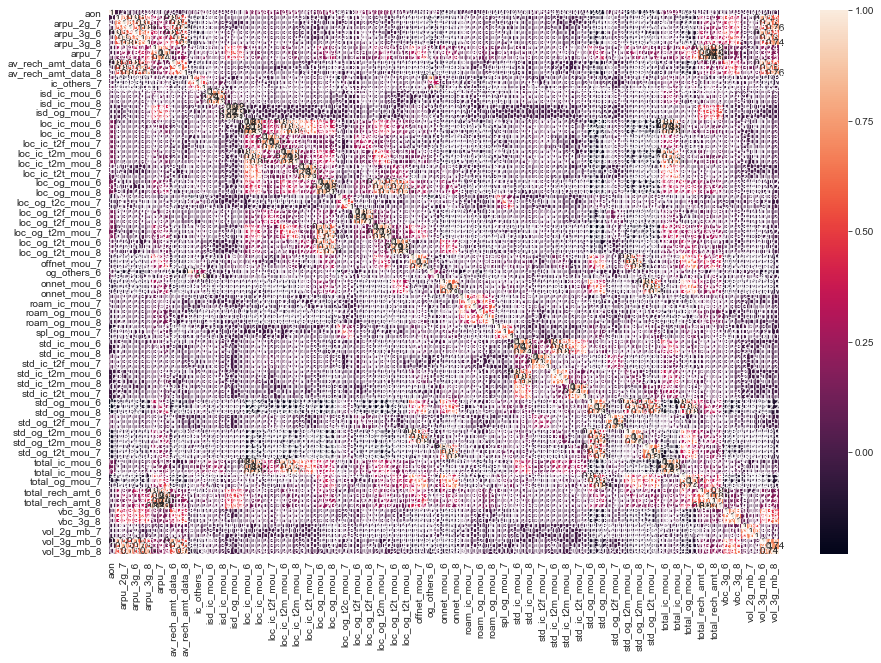

In [51]:
df_corr = np.round(df[cols_all_num].corr(),2)
sns.set_style("white")
plt.figure(figsize=(15,10))
sns.heatmap(df_corr, annot=True)
plt.show()

In [52]:
cols_all_cat = get_fld_list(df, "cat")

In [53]:
df[cols_all_cat].head(5)

count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  \
7               1.0              1.0              0.0              0.0   
8               1.0              2.0              3.0              0.0   
13              1.0              1.0              3.0              0.0   
16              1.0              1.0              1.0              0.0   
17              1.0              1.0              1.0              0.0   

    count_rech_3g_7  count_rech_3g_8  date_of_last_rech_6  \
7               0.0              0.0                 27.0   
8               0.0              0.0                 25.0   
13              0.0              0.0                 20.0   
16              0.0              0.0                 30.0   
17              0.0              0.0                 30.0   

    date_of_last_rech_7  date_of_last_rech_8  date_of_last_rech_data_6  \
7                  25.0                 26.0                      27.0   
8                  31.0                 30.0                      29.0   
13                 22.0                 30.0                      26.0   
16                 31.0                 14.0                      29.0   
17                 30.0                 25.0                      24.0   

          ...         sachet_3g_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  \
7         ...                   0          0.21           0.0           0.0   
8         ...                   0          0.00           0.0           0.0   
13        ...                   0          0.45           0.0           0.0   
16        ...                   0          0.00           0.0           0.0   
17        ...                   0          0.00           0.0           0.0   

    total_rech_data_6  total_rech_data_7  total_rech_data_8  total_rech_num_6  \
7                 1.0                1.0                1.0                 5   
8                 1.0                2.0                3.0                19   
13                1.0                1.0                3.0                 6   
16                1.0                1.0                1.0                10   
17                1.0                1.0                1.0                19   

    total_rech_num_7  total_rech_num_8  
7                  5                 7  
8                 21                14  
13                 4                11  
16                 6                 2  
17                 2                 4  

[5 rows x 49 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30011 entries, 0 to 30010
Columns: 161 entries, Unnamed: 0 to vbc_3g_6
dtypes: float64(139), int64(22)
memory usage: 36.9 MB


In [55]:
#df= df1.copy()

In [8]:
#All above identified categorical variables also has very little decimal digit difference from each others
#Therefore it makes sense to truncate those from float to integer. 
#It will help in outlier identification & consolidating datapoints. 
#Which in turns will help in creating a stable and less complex model.
#This also occupies lessor memory 
cols_all_cat = get_fld_list(df, "cat")
for col in cols_all_cat:
    df[col] = df[col].apply( lambda x: int(round(x,0)))
    df[col] = df[col].astype("int16")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30011 entries, 0 to 30010
Columns: 161 entries, Unnamed: 0 to vbc_3g_6
dtypes: float64(109), int16(49), int64(3)
memory usage: 28.4 MB


<font color=red size=5> Find & Remove Outliers</font>

<font color=red size=3>__Identify Categorical (Binary) Value Fields__</font>

In [13]:
#Columns which contains only 2 categorical values
cols_all_bin = get_fld_list(df, "bin")
df[cols_all_bin].head()

fb_user_6  fb_user_7  fb_user_8  night_pck_user_6  night_pck_user_7  \
0          1          1          1                 0                 0   
1          1          1          1                 0                 0   
2          0          0          1                 0                 0   
3          0          0          0                 0                 0   
4          0          1          1                 0                 0   

   night_pck_user_8  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

<font color=red size=3>__Identify Outliers in Categorical Fields__</font>

In [ ]:
#In this solution I am using categorical variable so this step not required.

In [59]:
#df=df2.copy()

## Binning categorical Fields

In [32]:
all_cols = list(df.columns)

#Binary varlue columns
cols_all_bin = get_fld_list(df,"bin")

#Binning should not be done for binary value columns
all_cols = list(set(all_cols).difference( set(cols_all_bin)))

#no binning for mobile_number
all_cols.remove("mobile_number")

#no binning for target variable
all_cols.remove(target_)

all_cols.sort()
#df[all_cols].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9]).to_csv("desc.csv")

In [33]:
#create bin range
bin_dict = {'arpu_2g': [-5000,0,50,100,200,500,1000,2000,5000,50000],
'arpu_3g': [-5000,0,50,100,200,500,1000,2000,5000,50000],
'arpu': [-5000,0,50,100,200,500,1000,2000,5000,50000],
'av_rech_amt_data': [-2000,0,100,200,300,500,1000,5000,10000],
'count_rech_2g': [0,5,10,20,100],
'count_rech_3g': [0,5,10,20,100],
'date_of_last_rech': [1,5,10,15,20,25,32],
'date_of_last_rech_data': [1,5,10,15,20,25,32],
'ic_others': [-500,0,100,500,1000,2000],
'isd_ic_mou': [0,100,500,1000,5000,10000],
'isd_og_mou': [0,100,500,1000,5000,10000],
'last_day_rch_amt': [0,50,100,200,500,1000,2000,4000,6000,8000],
'loc_ic_mou': [0,50,100,200,500,1000,2000,4000,6000,8000],
'loc_ic_t2f_mou': [0,10,20,50,100,500,1000,2000,5000],
'loc_ic_t2m_mou': [0,10,20,50,100,500,1000,2000,5000],
'loc_ic_t2t_mou': [0,10,20,50,100,500,1000,2000,5000],
'loc_og_mou': [0,100,200,500,1000,2000,5000,10000,15000],
'loc_og_t2c_mou': [0,5,10,50,100,500,2000],
'loc_og_t2f_mou': [0,5,10,50,100,500,2000],
'loc_og_t2m_mou': [0,10,20,50,100,500,1000,2000,5000,10000],
'loc_og_t2t_mou': [0,10,20,50,100,500,1000,2000,5000,10000],
'max_rech_amt': [0,50,100,150,200,300,500,1000,5000],
'max_rech_data': [0,50,100,150,200,300,500,1000,5000],
'monthly_2g': [0,1,2,3,4,5,10,20],
'monthly_3g': [0,1,2,3,4,5,10,20],
'night_pck_user': [0,1,2,3,4,5,10,20],
'offnet_mou': [0,50,100,200,500,1000,2000,5000,10000,20000],
'og_others': [0,5,10,20,50,100,500],
'onnet_mou': [0,50,100,200,500,1000,2000,5000,10000],
'roam_ic_mou': [0,50,100,200,500,1000,2000,10000],
'roam_og_mou': [0,50,100,200,500,1000,2000,10000],
'sachet_2g': [0,5,10,15,20,50],
'sachet_3g': [0,5,10,15,20,50],
'spl_ic_mou': [0,5,10,15,20,50,100,500,1000,2000],
'spl_og_mou': [0,5,10,15,20,50,100,500,1000,2000],
'std_ic_mou': [0,5,10,15,20,50,100,500,1000,2000,5000,10000],
'std_ic_t2f_mou': [0,5,10,15,20,50,100,500,1000,2000],
'std_ic_t2m_mou': [0,5,10,15,20,50,100,500,1000,2000,5000],
'std_ic_t2t_mou': [0,5,10,15,20,50,100,500,1000,2000,5000,10000],
'std_og_mou': [0,10,15,20,50,100,500,1000,2000,5000,10000,20000],
'std_og_t2f_mou': [0,5,10,50,100,500,1000],
'std_og_t2m_mou': [0,10,15,20,50,100,500,1000,2000,5000,10000,20000],
'std_og_t2t_mou': [0,5,10,15,20,50,100,500,1000,2000,5000,10000],
'total_ic_mou': [0,10,15,20,50,100,500,1000,2000,5000,10000,20000],
'total_og_mou': [0,10,15,20,50,100,500,1000,2000,5000,10000,20000],
'total_rech_amt': [0,200,500,1000,2000,5000,10000,20000,50000],
'total_rech_data': [1,5,10,20,50,100,200,500],
'total_rech_num': [5,10,20,50,100,500],
'vbc_3g': [0,50,100,200,500,1000,5000,10000,20000],
'vol_2g_mb': [0,50,100,200,500,1000,5000,10000,20000],
'vol_3g_mb': [0,500,1000,5000,10000,20000,50000],
'aon': [0,100,200,300,500,1000,2000,5000],
'total_rech_amt_avg': [0,500,1000,5000,10000,20000,50000]
}

In [34]:
#Define Labels of each bin
bin_label_dict={
'arpu_2g':['<0','<50','<100','<200','<500','<1000','<2000','<5000','<50000'],
'arpu_3g':['<0','<50','<100','<200','<500','<1000','<2000','<5000','<50000'],
'arpu':['<0','<50','<100','<200','<500','<1000','<2000','<5000','<50000'],
'av_rech_amt_data':['<0','<100','<200','<300','<500','<1000','<5000','<10000'],
'count_rech_2g':['<5','<10','<20','<100'],
'count_rech_3g':['<5','<10','<20','<100'],
'date_of_last_rech':['<5','<10','<15','<20','<25','<32'],
'date_of_last_rech_data':['<5','<10','<15','<20','<25','<32'],
'ic_others':['<0','<100','<500','<1000','<2000'],
'isd_ic_mou':['<100','<500','<1000','<5000','<10000'],
'isd_og_mou':['<100','<500','<1000','<5000','<10000'],
'last_day_rch_amt':['<50','<100','<200','<500','<1000','<2000','<4000','<6000','<8000'],
'loc_ic_mou':['<50','<100','<200','<500','<1000','<2000','<4000','<6000','<8000'],
'loc_ic_t2f_mou':['<10','<20','<50','<100','<500','<1000','<2000','<5000'],
'loc_ic_t2m_mou':['<10','<20','<50','<100','<500','<1000','<2000','<5000'],
'loc_ic_t2t_mou':['<10','<20','<50','<100','<500','<1000','<2000','<5000'],
'loc_og_mou':['<100','<200','<500','<1000','<2000','<5000','<10000','<15000'],
'loc_og_t2c_mou':['<5','<10','<50','<100','<500','<2000'],
'loc_og_t2f_mou':['<5','<10','<50','<100','<500','<2000'],
'loc_og_t2m_mou':['<10','<20','<50','<100','<500','<1000','<2000','<5000','<10000'],
'loc_og_t2t_mou':['<10','<20','<50','<100','<500','<1000','<2000','<5000','<10000'],
'max_rech_amt':['<50','<100','<150','<200','<300','<500','<1000','<5000'],
'max_rech_data':['<50','<100','<150','<200','<300','<500','<1000','<5000'],
'monthly_2g':['<1','<2','<3','<4','<5','<10','<20'],
'monthly_3g':['<1','<2','<3','<4','<5','<10','<20'],
'night_pck_user':['<1','<2','<3','<4','<5','<10','<20'],
'offnet_mou':['<50','<100','<200','<500','<1000','<2000','<5000','<10000','<20000'],
'og_others':['<5','<10','<20','<50','<100','<500'],
'onnet_mou':['<50','<100','<200','<500','<1000','<2000','<5000','<10000'],
'roam_ic_mou':['<50','<100','<200','<500','<1000','<2000','<10000'],
'roam_og_mou':['<50','<100','<200','<500','<1000','<2000','<10000'],
'sachet_2g':['<5','<10','<15','<20','<50'],
'sachet_3g':['<5','<10','<15','<20','<50'],
'spl_ic_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000'],
'spl_og_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000'],
'std_ic_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000'],
'std_ic_t2f_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000'],
'std_ic_t2m_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000','<5000'],
'std_ic_t2t_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000'],
'std_og_mou':['<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000','<20000'],
'std_og_t2f_mou':['<5','<10','<50','<100','<500','<1000'],
'std_og_t2m_mou':['<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000','<20000'],
'std_og_t2t_mou':['<5','<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000'],
'total_ic_mou':['<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000','<20000'],
'total_og_mou':['<10','<15','<20','<50','<100','<500','<1000','<2000','<5000','<10000','<20000'],
'total_rech_amt':['<200','<500','<1000','<2000','<5000','<10000','<20000','<50000'],
'total_rech_data':['<5','<10','<20','<50','<100','<200','<500'],
'total_rech_num':['<10','<20','<50','<100','<500'],
'vbc_3g':['<50','<100','<200','<500','<1000','<5000','<10000','<20000'],
'vol_2g_mb':['<50','<100','<200','<500','<1000','<5000','<10000','<20000'],
'vol_3g_mb':['<500','<1000','<5000','<10000','<20000','<50000'],
'aon':['<100','<200','<300','<500','<1000','<2000','<5000'],
'total_rech_amt_avg':['<500','<1000','<5000','<10000','<20000','<50000']

}

In [35]:
def col_bin(col):
    return bin_dict[ col ]

def col_bin_label(col):
    return bin_label_dict[ col]

In [36]:
#Turn cols into bins
#these 2 columns do not have monthly data so handling differently
all_cols.remove("total_rech_amt_avg")
all_cols.remove("aon")

for col in all_cols:
    ld= col.split("_")
    if len(ld)>1 and (ld[-1])>"0":
        print ("Creating bin for",col)
        df[col] = pd.cut( df[col],bins  = col_bin((col[0:len(col)-2])), 
                                  labels= col_bin_label((col[0:len(col)-2])), 
                         include_lowest=True)

#These two columns do not have monthly data, so handling differently.

col="aon"
df[col] = pd.cut( df[col],bins  = col_bin(col), 
                                  labels= col_bin_label(col), 
                         include_lowest=True)
print ("Creating bin for",col)

col="total_rech_amt_avg"
df[col] = pd.cut( df[col],bins  = col_bin(col), 
                                  labels= col_bin_label(col), 
                         include_lowest=True)
print ("Creating bin for",col)

Creating bin for arpu_2g_6
Creating bin for arpu_2g_7
Creating bin for arpu_2g_8
Creating bin for arpu_3g_6
Creating bin for arpu_3g_7
Creating bin for arpu_3g_8
Creating bin for arpu_6
Creating bin for arpu_7
Creating bin for arpu_8
Creating bin for av_rech_amt_data_6
Creating bin for av_rech_amt_data_7
Creating bin for av_rech_amt_data_8
Creating bin for count_rech_2g_6
Creating bin for count_rech_2g_7
Creating bin for count_rech_2g_8
Creating bin for count_rech_3g_6
Creating bin for count_rech_3g_7
Creating bin for count_rech_3g_8
Creating bin for date_of_last_rech_6
Creating bin for date_of_last_rech_7
Creating bin for date_of_last_rech_8
Creating bin for date_of_last_rech_data_6
Creating bin for date_of_last_rech_data_7
Creating bin for date_of_last_rech_data_8
Creating bin for ic_others_6
Creating bin for ic_others_7
Creating bin for ic_others_8
Creating bin for isd_ic_mou_6
Creating bin for isd_ic_mou_7
Creating bin for isd_ic_mou_8
Creating bin for isd_og_mou_6
Creating bin for

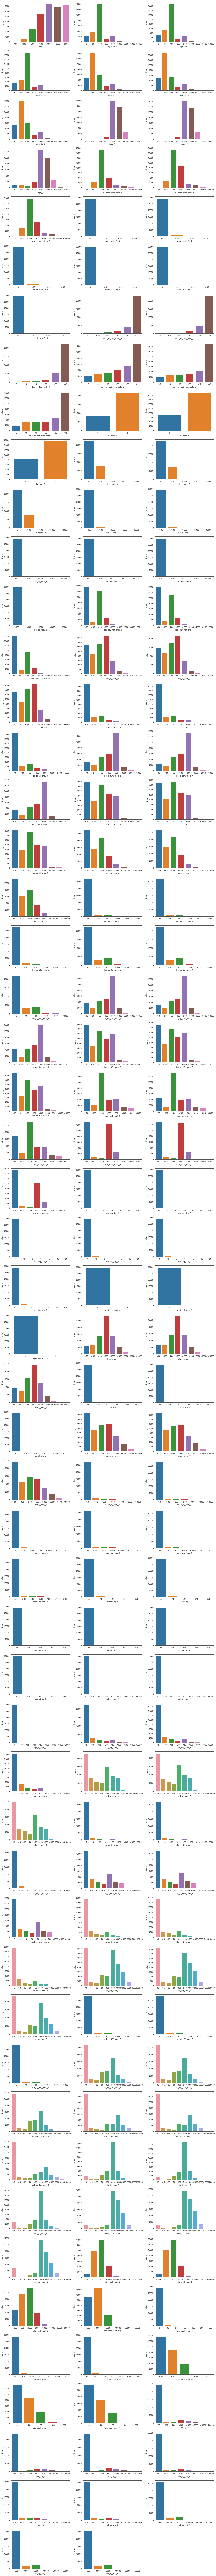

In [65]:
#Visualize distribution of fields
cols_all_cat = get_fld_list(df, "cat")
plt.figure(figsize=(15,200))
i=1
for col  in cols_all_cat:
    plt.subplot(60, 3,i)
    sns.barplot( x=df[col], y=df[target_], estimator=len )
    i+=1
    
plt.tight_layout()

In [15]:
cols_all_cat = get_fld_list(df, "cat")
len(cols_all_cat)

158

In [22]:
df.shape

(30011, 161)

<font color=red size=3>__Identify Outliers in Numerical Fields__</font>

<font color=red size=3> Visualize Outliers Distribution</font>

In [ ]:
#Using binning I have converted all variables into cat. So not required in this solution.
#DecisionTree/Random Forest will take care of everything

<font color=red size=3> Remove Outliers</font>

In [67]:
#Using binning I have converted all variables into cat. So not required in this solution.
#DecisionTree/Random Forest will take care of everything

<font color=red size=3> Visualize Again : Distribution of Old Outlier Fields</font>

In [68]:
#Using binning I have converted all variables into cat. So not required in this solution.
#DecisionTree/Random Forest will take care of everything

<font color=red size=4>__Create Dummy Variable for all Categorical Variables__</font>

In [23]:
df.shape

(30011, 161)

In [37]:
#Create dummy fields of categorical variables
dummies=[]
for col in cols_all_cat:
    dummies.append( pd.get_dummies(df[col], drop_first=True, prefix=col) )

In [38]:
#concat all dummy fields into df

i=0
while i < len(dummies):
    if i==0:
        df_combine = dummies[0]
    else:
        df_combine = pd.concat([df_combine, dummies[i]], axis=1)
    i+=1
    
#drop original cat fields
df.drop(columns=cols_all_cat, inplace=True)

#concat dummy field in dataset
df = pd.concat([df, df_combine], axis=1)

In [39]:
df.shape

(30011, 1037)

<font color=red size=6>__Preparation for Modeling__</font>

<font color=red size=3>__Split Dataset & Scale Numeric Fields__</font>

In [45]:
#Split Dataset in X & y
Xcols = list(df.columns)
Xcols.remove(target_)

X = df[Xcols]
y = df[target_]

In [46]:
# split X, y into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
X_train_id = X_train[id_]
X_test_id = X_test[id_]

X_train = X_train.drop(columns=id_)
X_test = X_test.drop(columns=id_)

In [47]:
X_train.head(2)

aon_<200  aon_<300  aon_<500  aon_<1000  aon_<2000  aon_<5000  \
1434         0         0         1          0          0          0   
4636         0         0         0          0          1          0   

      arpu_2g_6_<50  arpu_2g_6_<100  arpu_2g_6_<200  arpu_2g_6_<500  \
1434              0               1               0               0   
4636              1               0               0               0   

             ...          vol_3g_mb_7_<1000  vol_3g_mb_7_<5000  \
1434         ...                          0                  0   
4636         ...                          0                  0   

      vol_3g_mb_7_<10000  vol_3g_mb_7_<20000  vol_3g_mb_7_<50000  \
1434                   0                   0                   0   
4636                   0                   0                   0   

      vol_3g_mb_8_<1000  vol_3g_mb_8_<5000  vol_3g_mb_8_<10000  \
1434                  0                  0                   0   
4636                  0                  0                   0   

      vol_3g_mb_8_<20000  vol_3g_mb_8_<50000  
1434                   0                   0  
4636                   0                   0  

[2 rows x 1034 columns]

### scaling the numeric feature features in train and test

#### Because all variables are categorical so not required in this solution

In [48]:
X_train.head(2)

aon_<200  aon_<300  aon_<500  aon_<1000  aon_<2000  aon_<5000  \
1434         0         0         1          0          0          0   
4636         0         0         0          0          1          0   

      arpu_2g_6_<50  arpu_2g_6_<100  arpu_2g_6_<200  arpu_2g_6_<500  \
1434              0               1               0               0   
4636              1               0               0               0   

             ...          vol_3g_mb_7_<1000  vol_3g_mb_7_<5000  \
1434         ...                          0                  0   
4636         ...                          0                  0   

      vol_3g_mb_7_<10000  vol_3g_mb_7_<20000  vol_3g_mb_7_<50000  \
1434                   0                   0                   0   
4636                   0                   0                   0   

      vol_3g_mb_8_<1000  vol_3g_mb_8_<5000  vol_3g_mb_8_<10000  \
1434                  0                  0                   0   
4636                  0                  0                   0   

      vol_3g_mb_8_<20000  vol_3g_mb_8_<50000  
1434                   0                   0  
4636                   0                   0  

[2 rows x 1034 columns]

In [49]:
print(y_train.mean())
print(y_test.mean())

0.08678059694387585
0.08551754775655264


<font color=red size=3>__PCA Compression/ Dimentionality Reduction__</font>

In [74]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver="randomized",random_state=100)
pca.fit(X_train)

colnames = list(X_train.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[3],'PC4':pca.components_[4], 'Feature':colnames})
pca_df['Feature'].head(10)

0          aon_<200
1          aon_<300
2          aon_<500
3         aon_<1000
4         aon_<2000
5         aon_<5000
6     arpu_2g_6_<50
7    arpu_2g_6_<100
8    arpu_2g_6_<200
9    arpu_2g_6_<500
Name: Feature, dtype: object

In [75]:
pca_df.shape

(1034, 5)

In [76]:
pca_df.head()

PC1       PC2       PC3       PC4    Feature
0 -0.005473  0.001450 -0.000439  0.001150   aon_<200
1 -0.015780  0.007014 -0.002529  0.002681   aon_<300
2 -0.039373  0.003169 -0.014273  0.011509   aon_<500
3 -0.051343  0.012260 -0.022341  0.006633  aon_<1000
4  0.014980 -0.009535 -0.009454 -0.006734  aon_<2000

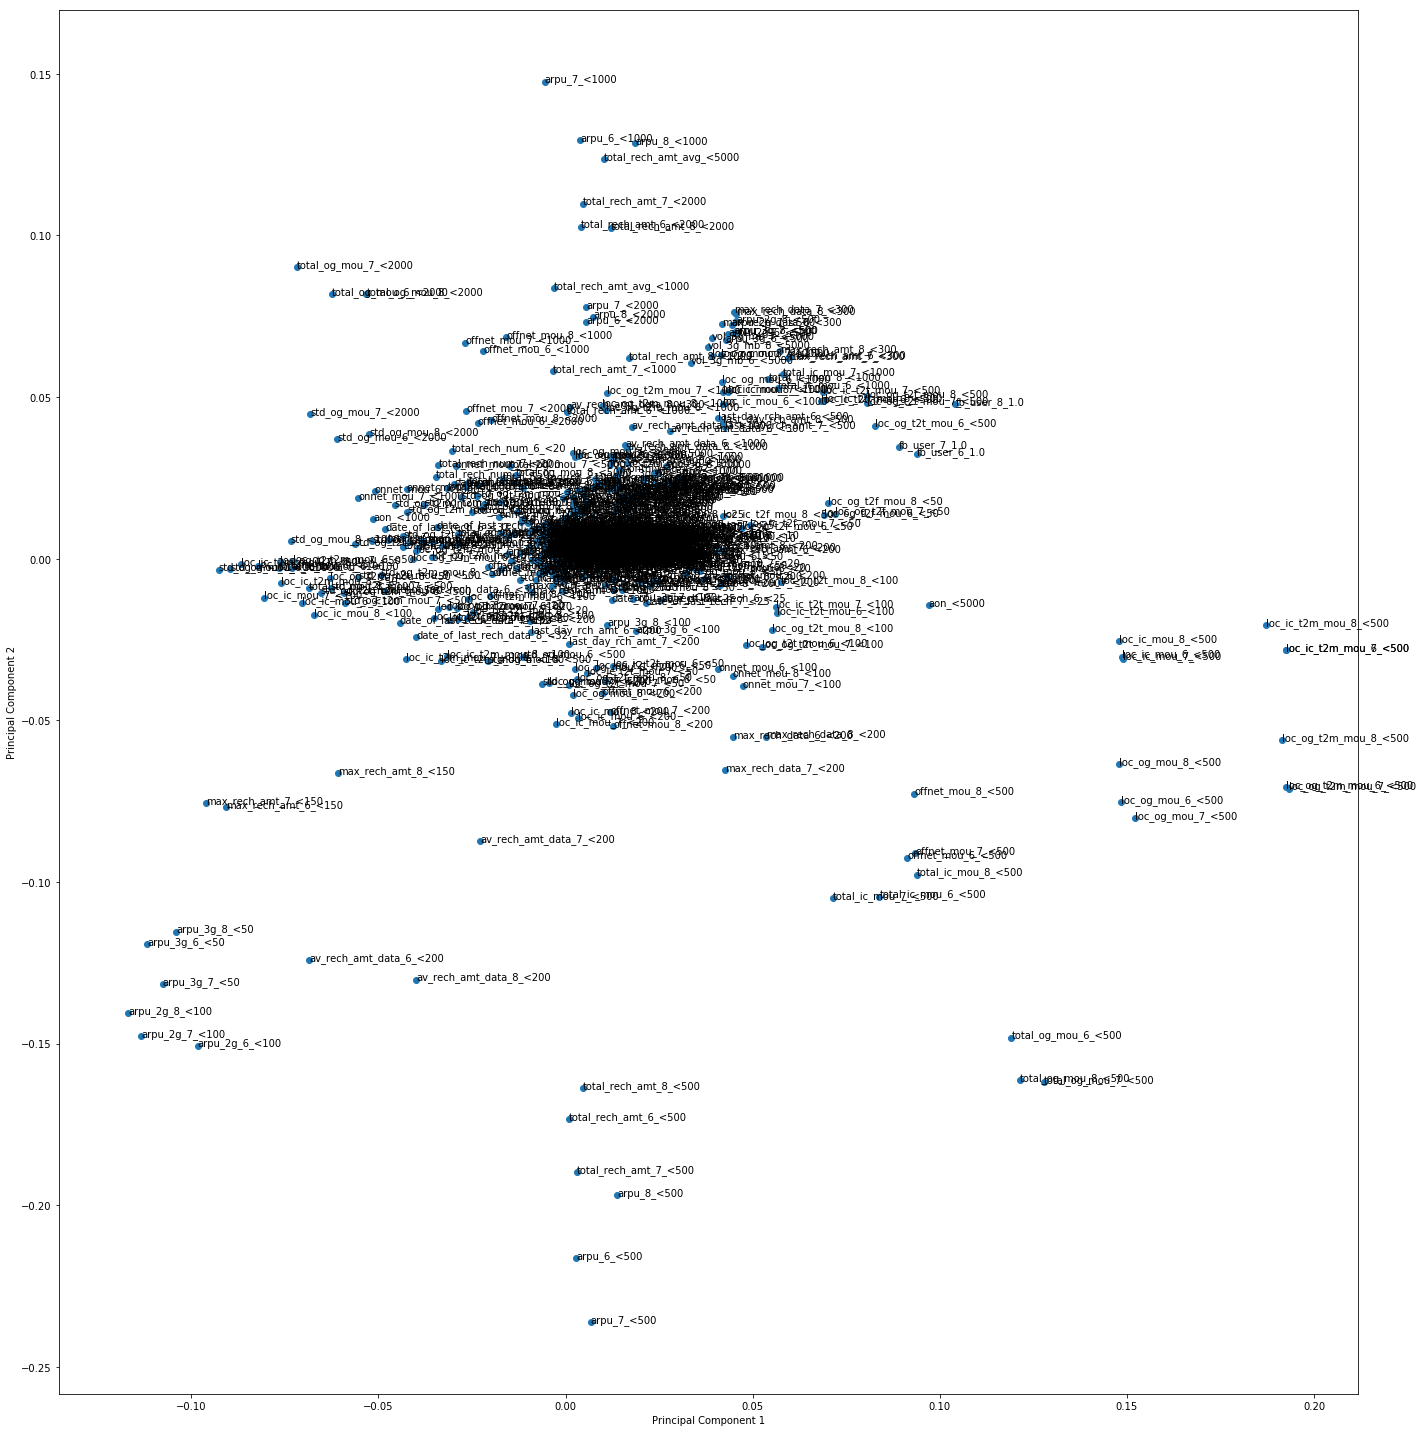

In [77]:
%matplotlib inline
fig = plt.figure(figsize = (20,20))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pca_df.Feature):
    plt.annotate(txt, (pca_df.PC1[i],pca_df.PC2[i]))
plt.tight_layout()
plt.show()

In [55]:
pca.explained_variance_ratio_

array([4.40040203e-02, 3.24873813e-02, 3.20117998e-02, ...,
       2.32076318e-34, 2.32076318e-34, 4.83613027e-36])

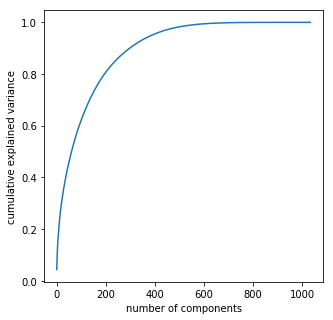

In [144]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [145]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=400)

X_train_pca = pca_final.fit_transform(X_train)
X_train_pca.shape

(21007, 400)

In [146]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())

In [147]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.004152718188334821 , min corr:  -0.003209333549892757


In [148]:
#Applying selected components to the test data - 16 components
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(9004, 400)

In [149]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca,y_train)

In [150]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(X_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.91'

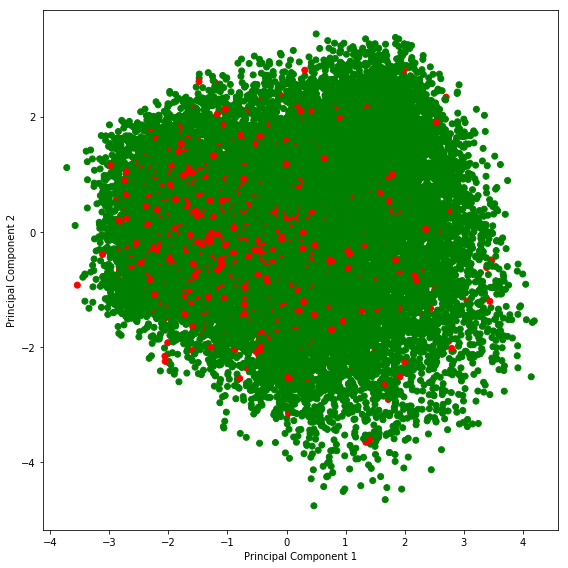

In [151]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [152]:
X_train_pca.shape
#y_train.shape

(21007, 400)

In [153]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#Only 1 PCA feature can explain 99.99% of variance

array([ 4.4 ,  7.65, 10.85, ..., 99.71, 99.71, 99.71])

<font color=red size=3>__PCA Feature Engineering__</font>

In [82]:
#Not Required

<font color=red size=6>__Start Modeling__</font>

<font color=red size=3>Commonly Used Custom Function - Required in Modelling</font>

In [92]:
def predict_with_prob(model,y_, X_):
    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"act_churn": y_, "churn_prob":list(y_pred[:,1]) })

    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df_pred[i]= df_pred.churn_prob.map(lambda x: 1 if x > i else 0)
    return df_pred

In [120]:
def create_metrics_table(df_pred):
    df_cutoff = pd.DataFrame( columns = ['prob','accuracy','recall','specificity','fpr','precision'])
    from sklearn.metrics import confusion_matrix

    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df_pred.act_churn, df_pred[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        fpr = 1-specificity
        recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
        df_cutoff.loc[i] =[ i ,accuracy,recall,specificity,fpr,precision]
    return df_cutoff

In [115]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
def plot_roc(df_cutoff):
    plt.figure(figsize=(15,3))
    sns.lineplot(x="fpr", y='recall', data=df_cutoff, color="red")
    plt.show()

In [123]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
def plot_cutoff(df_cutoff):
    plt.figure(figsize=(15,3))
    sns.lineplot(x="prob", y='accuracy', data=df_cutoff, color="red")
    sns.lineplot(x="prob", y='recall'  , data=df_cutoff, color="green")
    sns.lineplot(x="prob", y='specificity'   , data=df_cutoff, color="blue")
    sns.lineplot(x="prob", y='fpr'   , data=df_cutoff, color="magenta")
    sns.lineplot(x="prob", y='precision'   , data=df_cutoff, color="black")
    
    plt.legend(["Accuracy","Recall","specificity","fpr","precision"])
    plt.show()

In [118]:
def predict_score(model, y_act, X_, probability):
    
    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"y_actual": y_act, "pred_prob":list(y_pred[:,1]) })
    df_pred["y_pred"] = df_pred["pred_prob"].apply(lambda x: 1 if x>probability else 0)
    
    cm1 = metrics.confusion_matrix(y_act, df_pred.y_pred )
    total1=sum(sum(cm1))

    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    fpr = 1- specificity
    recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    f1 = metrics.f1_score(y_act, df_pred.y_pred)
        
    print ("Accuracy:   \t", accuracy )
    print ("Recall:     \t", recall )
    print ("Specificity:\t", specificity )
    print ("FPR:        \t", fpr)
    print ("Precision:  \t", precision )
    print ("f1:         \t",f1)
    
    print ("Confusion Matrix:\n", metrics.confusion_matrix(y_act, df_pred.y_pred) )

In [96]:
# plotting model parameters against the metrics
def plot_gridSearch_para(df_grid, parameters, matrix):
    plt.figure(figsize=(15,15))
    i=1
    for parameter in parameters:
        plt.subplot(6,3,i)
        i+=1

        sns.lineplot(x=df_grid[parameter], 
                     y=df_grid["mean_train_score"], 
                     label="training accuracy")

        sns.lineplot(x= df_grid[parameter], 
                 y= df_grid["mean_test_score"], 
                 label="test accuracy")

        #plt.xlabel("max_features")
        plt.ylabel(matrix)
        plt.legend()
    plt.show()

<font color=red size=6>__Logistic Regression__</font>

<font color=red size=3>__Logistic Regression Using PCA Features__</font>

In [154]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced")
model_lr.fit(X_train_pca,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

     prob  accuracy    recall  specificity       fpr  precision
0.0   0.0  0.086781  1.000000     0.000000  1.000000   0.086781
0.1   0.1  0.526063  0.986286     0.482329  0.517671   0.153295
0.2   0.2  0.682296  0.967636     0.655181  0.344819   0.210526
0.3   0.3  0.769363  0.939111     0.753232  0.246768   0.265591
0.4   0.4  0.821298  0.897422     0.814064  0.185936   0.314434
0.5   0.5  0.859713  0.849698     0.860665  0.139335   0.366888
0.6   0.6  0.887038  0.798683     0.895434  0.104566   0.420566
0.7   0.7  0.906269  0.727921     0.923217  0.076783   0.473929
0.8   0.8  0.921122  0.646188     0.947248  0.052752   0.537900
0.9   0.9  0.930071  0.491498     0.971747  0.028253   0.623088


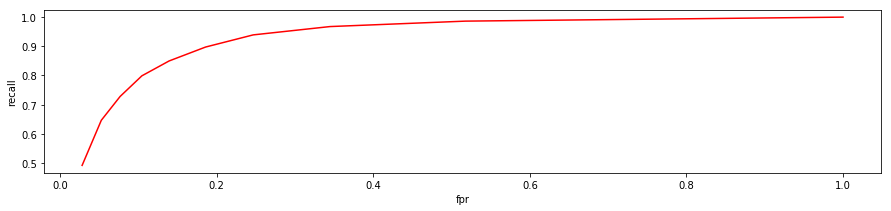

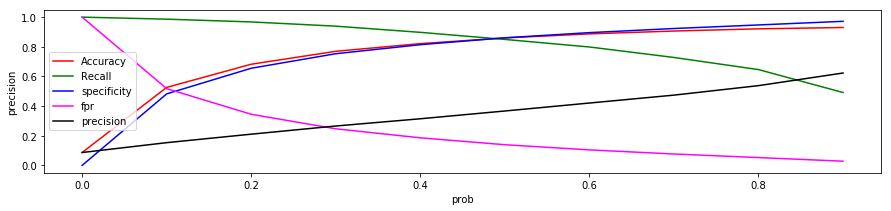

In [156]:
#Visualize the result on train data
df_pred=predict_with_prob(model_lr,y_train,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)
plot_cutoff(df_cutoff)

     prob  accuracy    recall  specificity       fpr  precision
0.0   0.0  0.085518  1.000000     0.000000  1.000000   0.085518
0.1   0.1  0.515549  0.962338     0.473767  0.526233   0.146039
0.2   0.2  0.666593  0.922078     0.642701  0.357299   0.194414
0.3   0.3  0.753221  0.888312     0.740588  0.259412   0.242553
0.4   0.4  0.812084  0.849351     0.808598  0.191402   0.293274
0.5   0.5  0.852621  0.815584     0.856085  0.143915   0.346387
0.6   0.6  0.884052  0.777922     0.893976  0.106024   0.406929
0.7   0.7  0.905375  0.719481     0.922759  0.077241   0.465546
0.8   0.8  0.921035  0.625974     0.948628  0.051372   0.532597
0.9   0.9  0.929143  0.476623     0.971460  0.028540   0.609635


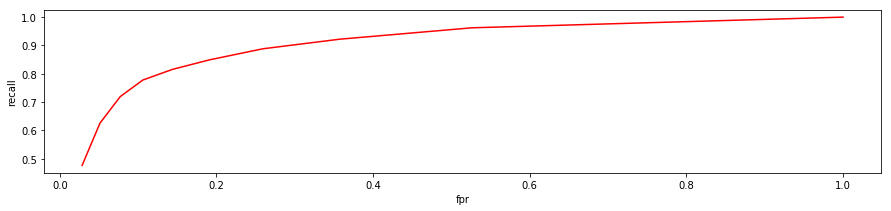

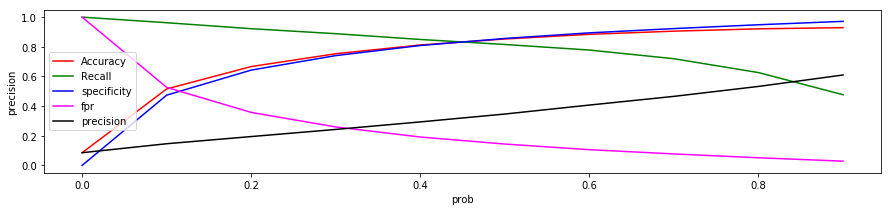

In [157]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)
plot_cutoff(df_cutoff)

In [158]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train, X_train_pca, .50)

Accuracy:   	 0.8597134288570476
Recall:     	 0.8496982995063083
Specificity:	 0.8606651376146789
FPR:        	 0.1393348623853211
Precision:  	 0.36688773093320703
f1:         	 0.5124896608767577
Confusion Matrix:
 [[16511  2673]
 [  274  1549]]


In [160]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_test, X_test_pca, .50)

Accuracy:   	 0.8526210573078632
Recall:     	 0.8155844155844156
Specificity:	 0.856084527568618
FPR:        	 0.14391547243138203
Precision:  	 0.3463872035300607
f1:         	 0.4862562911343399
Confusion Matrix:
 [[7049 1185]
 [ 142  628]]


In [161]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test, X_test_pca, .80)

Accuracy:   	 0.9210350955131053
Recall:     	 0.625974025974026
Specificity:	 0.9486276414865193
FPR:        	 0.051372358513480654
Precision:  	 0.532596685082873
f1:         	 0.5755223880597016
Confusion Matrix:
 [[7811  423]
 [ 288  482]]


<font color=red size=3>__Logistic Regression Using Normal Features__</font>

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
model_lr = LogisticRegression(class_weight="balanced")
rfe = RFE(model_lr, 20)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=20, step=1, verbose=0)

In [ ]:
#Visualize the result on train data
df_pred=predict_with_prob(rfe,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.085518  1.000000     0.000000   0.085518
0.1   0.1  0.580409  0.954545     0.545421   0.164136
0.2   0.2  0.706353  0.900000     0.688244   0.212577
0.3   0.3  0.778210  0.872727     0.769371   0.261377
0.4   0.4  0.827965  0.835065     0.827301   0.311380
0.5   0.5  0.865393  0.809091     0.870658   0.369076
0.6   0.6  0.891271  0.763636     0.903206   0.424549
0.7   0.7  0.909707  0.707792     0.928589   0.481024
0.8   0.8  0.920702  0.629870     0.947899   0.530635
0.9   0.9  0.930253  0.492208     0.971217   0.615260


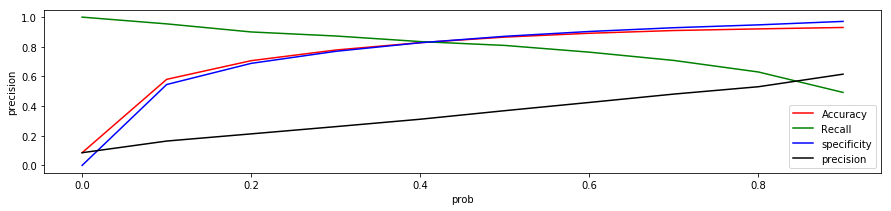

In [43]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test,X_test)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [44]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train, X_train, .30)

Accuracy:	 0.7999238349121721
Recall:  	 0.9577619308831596
Specificity:	 0.7849249374478732
Precision:	 0.2973433242506812
Confusion Matrix:
 [[15058  4126]
 [   77  1746]]


In [97]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test, X_test, .30)

Accuracy:	 0.7784318080852954
Recall:  	 0.8727272727272727
Specificity:	 0.7696137964537284
Precision:	 0.2615803814713896
Confusion Matrix:
 [[6337 1897]
 [  98  672]]


<font color=red size=6>__RandomForest Classifier__</font>

<font color=red size=3>__RandomForestClassfier Using PCA Features__</font>

In [98]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {"max_depth" : [2, 5],
              "n_estimators": [100, 200, 400],
              "max_features": [2],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }

model_rfc_pca = RandomForestClassifier(random_state=100, class_weight="balanced")

folds = 3
grid_search_rfc_pca = GridSearchCV(model_rfc_pca, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_rfc_pca.fit(X_train_pca,  y_train_pca)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   57.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=100,
                                              verbose=0, warm_start=False),
           

In [99]:
df_scores = pd.DataFrame( grid_search_rfc_pca.cv_results_)
df_scores.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.818468      0.051722         0.066820        0.005700   
1       1.552498      0.010596         0.116687        0.002935   
2       3.205722      0.115001         0.253329        0.033884   
3       1.525900      0.077535         0.076793        0.009249   
4       3.283515      0.047805         0.178853        0.007909   

  param_max_depth param_max_features param_min_samples_leaf  \
0               2                  2                     50   
1               2                  2                     50   
2               2                  2                     50   
3               5                  2                     50   
4               5                  2                     50   

  param_min_samples_split param_n_estimators  \
0                      50                100   
1                      50                200   
2                      50                400   
3                      50                100   
4                      50                200   

                                              params       ...         \
0  {'max_depth': 2, 'max_features': 2, 'min_sampl...       ...          
1  {'max_depth': 2, 'max_features': 2, 'min_sampl...       ...          
2  {'max_depth': 2, 'max_features': 2, 'min_sampl...       ...          
3  {'max_depth': 5, 'max_features': 2, 'min_sampl...       ...          
4  {'max_depth': 5, 'max_features': 2, 'min_sampl...       ...          

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.695273           0.695747         0.694173        0.001900   
1           0.695123           0.696361         0.694703        0.001554   
2           0.695114           0.697654         0.695174        0.002001   
3           0.687270           0.694883         0.691240        0.003117   
4           0.687232           0.696341         0.691770        0.003719   

   rank_test_score  split0_train_score  split1_train_score  \
0                3            0.702578            0.700746   
1                2            0.703535            0.700467   
2                1            0.703598            0.700318   
3                6            0.726737            0.727020   
4                5            0.727497            0.727322   

   split2_train_score  mean_train_score  std_train_score  
0            0.701128          0.701484         0.000789  
1            0.701336          0.701779         0.001291  
2            0.701953          0.701956         0.001339  
3            0.728050          0.727269         0.000564  
4            0.727728          0.727516         0.000166  

[5 rows x 21 columns]

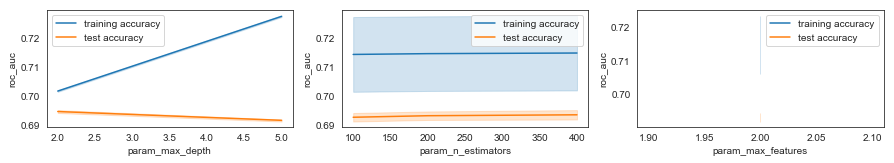

In [100]:
#para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_sample_split"]
para_list=["param_max_depth","param_n_estimators","param_max_features"]
plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier PCA Model Parameters__</font>

In [101]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_pca1 = RandomForestClassifier(max_depth=5,
                                        n_estimators=100,
                                        max_features=2,
                                        min_samples_leaf=50,
                                        min_samples_split=50,
                                        random_state=100, class_weight="balanced")

model_rfc_pca1.fit(X_train_pca, y_train_pca)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=2,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

<font color=red size=3>__Evaluating RandomForestClassifer PCA Model__</font>

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.115676  1.000000     0.031641   0.089363
0.2   0.2  0.259295  0.976961     0.191097   0.102954
0.3   0.3  0.401533  0.929238     0.351387   0.119827
0.4   0.4  0.494216  0.863961     0.459080   0.131777
0.5   0.5  0.588994  0.766868     0.572091   0.145519
0.6   0.6  0.695197  0.601207     0.704128   0.161843
0.7   0.7  0.905603  0.043335     0.987542   0.248428
0.8   0.8  0.913219  0.000000     1.000000        NaN
0.9   0.9  0.913219  0.000000     1.000000        NaN


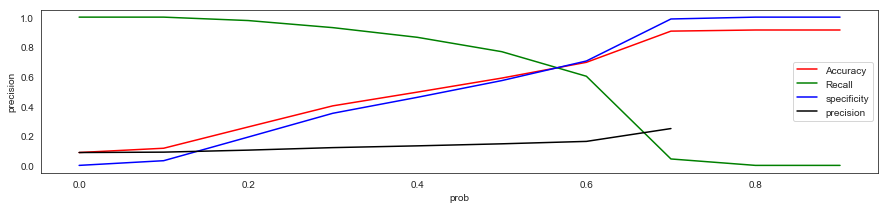

In [102]:
#Evaluate on Train Data
df_pred=predict_with_prob(model_rfc_pca1,y_train_pca,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [103]:
#Use optimum cutoff and see result on train data
predict_score(model_rfc_pca1, y_train_pca, X_train_pca, .50)

Accuracy:	 0.5889941448088732
Recall:  	 0.7668678003291278
Specificity:	 0.5720913261050876
Precision:	 0.14551889247423755
Confusion Matrix:
 [[10975  8209]
 [  425  1398]]


     prob  accuracy    recall  specificity  precision
0.0   0.0  0.085518  1.000000     0.000000   0.085518
0.1   0.1  0.114505  0.996104     0.032062   0.087788
0.2   0.2  0.256331  0.967532     0.189823   0.100458
0.3   0.3  0.390826  0.903896     0.342847   0.113968
0.4   0.4  0.486228  0.849351     0.452271   0.126646
0.5   0.5  0.582519  0.758442     0.566068   0.140486
0.6   0.6  0.685806  0.593506     0.694438   0.153717
0.7   0.7  0.908818  0.038961     0.990163   0.270270
0.8   0.8  0.914482  0.000000     1.000000        NaN
0.9   0.9  0.914482  0.000000     1.000000        NaN


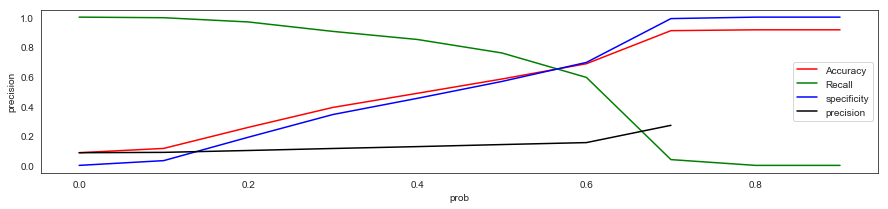

In [104]:
#Evaluate on Test Data
df_pred=predict_with_prob(model_rfc_pca1,y_test_pca,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [58]:
#Use optimum cutoff and see result on test data
predict_score(model_rfc_pca1, y_test_pca, X_test_pca, .50)

NameError: name 'model_rfc_pca1' is not defined

<font color=red size=5>__RandomForestClassifer using Normal Features__</font>

In [106]:
param_grid = {"max_depth" : [2,4,6],
              "n_estimators": [100, 200],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [50,100],
              "min_samples_split":[50,100]
              }

#### Disabled code below, because it is taking too much time, if I am rerunning again.
#I have done parameter tuning and put the hyperparamter values in the final solution.

<font color=red size=3>__Evaluating RandomForestClassifer Model__</font>

In [ ]:
#df_scores = pd.DataFrame( grid_search_rfc_nor.cv_results_)
#df_scores.head(5)

In [ ]:
#para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_samples_split"]
#plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier Model Parameters__</font>

In [45]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_nor1= RandomForestClassifier(max_depth=7,n_estimators=100,
                                       max_features=10,min_samples_leaf=50, 
                                       min_samples_split=50,class_weight="balanced", random_state=100)

model_rfc_nor1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=10,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=100, verbose=0, warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.086781  1.000000     0.000000   0.086781
0.2   0.2  0.086781  1.000000     0.000000   0.086781
0.3   0.3  0.196649  0.998354     0.120465   0.097363
0.4   0.4  0.555148  0.934723     0.519078   0.155901
0.5   0.5  0.862665  0.768513     0.871612   0.362578
0.6   0.6  0.930642  0.424575     0.978732   0.654822
0.7   0.7  0.931166  0.261657     0.994787   0.826690
0.8   0.8  0.915362  0.028524     0.999635   0.881356
0.9   0.9  0.913219  0.000000     1.000000        NaN


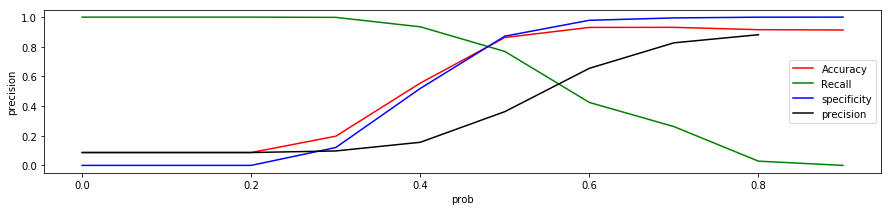

In [46]:
df_pred=predict_with_prob(model_rfc_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [ ]:
model_rfc_nor1.

In [57]:
predict_score(model_rfc_nor1, y_train, X_train, .50)

Accuracy:   	 0.8626648260103775
Recall:     	 0.7685134393856281
Specificity:	 0.8716117597998332
Precision:  	 0.36257763975155277
f1:         	 0.49270265517847717
Confusion Matrix:
 [[16721  2463]
 [  422  1401]]


In [110]:
predict_score(model_rfc_nor1, y_test, X_test, .30)

Accuracy:	 0.21945801865837405
Recall:  	 0.9922077922077922
Specificity:	 0.1471945591450085
Precision:	 0.09812483945543282
Confusion Matrix:
 [[1212 7022]
 [   6  764]]


<font color=red size=6>__DecisionTree__</font>

<font color=red size=3>__DecisionTree using Normal Features__</font>

In [111]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth" : [2, 5],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }
model_dt_nor = DecisionTreeClassifier(class_weight="balanced", random_state=100)

folds = 3
grid_search_dt_nor = GridSearchCV(model_dt_nor, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True, 
                               verbose = 1)

grid_search_dt_nor.fit(X_train,  y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    7.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 5], 'max_features': [10, 15, 20, 25],
                         'min_samples_leaf': [50], 

<font color=red size=3>__Evaluating DecisionTree Model__</font>

In [112]:
df_scores = pd.DataFrame( grid_search_dt_nor.cv_results_)
df_scores.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.174199      0.003672         0.049202        0.000470   
1       0.178188      0.005777         0.050531        0.001695   
2       0.170542      0.000814         0.049867        0.000814   
3       0.179518      0.007853         0.048204        0.001244   
4       0.183174      0.008237         0.049867        0.002443   

  param_max_depth param_max_features param_min_samples_leaf  \
0               2                 10                     50   
1               2                 15                     50   
2               2                 20                     50   
3               2                 25                     50   
4               5                 10                     50   

  param_min_samples_split                                             params  \
0                      50  {'max_depth': 2, 'max_features': 10, 'min_samp...   
1                      50  {'max_depth': 2, 'max_features': 15, 'min_samp...   
2                      50  {'max_depth': 2, 'max_features': 20, 'min_samp...   
3                      50  {'max_depth': 2, 'max_features': 25, 'min_samp...   
4                      50  {'max_depth': 5, 'max_features': 10, 'min_samp...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0           0.628184           0.649734           0.644040         0.640653   
1           0.589672           0.602970           0.600658         0.597766   
2           0.639169           0.661020           0.658852         0.653013   
3           0.643366           0.650699           0.648385         0.647484   
4           0.684683           0.705358           0.692963         0.694335   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.009118                7            0.646981            0.636309   
1        0.005801                8            0.601841            0.595171   
2        0.009830                5            0.659914            0.649046   
3        0.003061                6            0.649550            0.645853   
4        0.008497                4            0.709490            0.700434   

   split2_train_score  mean_train_score  std_train_score  
0            0.639098          0.640796         0.004519  
1            0.596321          0.597778         0.002911  
2            0.650116          0.653025         0.004891  
3            0.646999          0.647467         0.001545  
4            0.705051          0.704992         0.003697

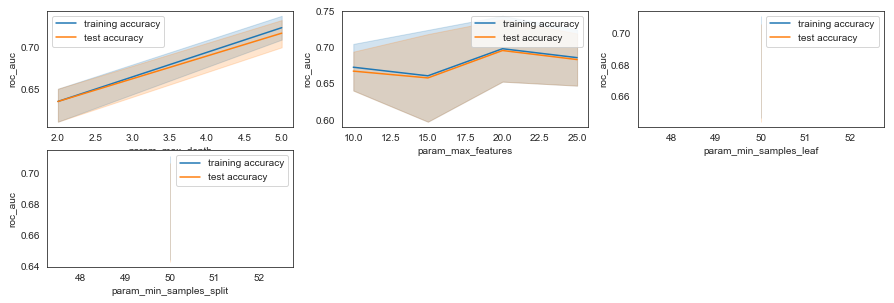

In [113]:
para_list=["param_max_depth","param_max_features","param_min_samples_leaf","param_min_samples_split"]

plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising DecisionTree Model Parameters__</font>

In [114]:
model_dt_nor1 = DecisionTreeClassifier(max_depth=5, max_features=10,
                                      min_samples_leaf=50, min_samples_split=50)
model_dt_nor1.fit(X_train.values.tolist(), y_train.values.tolist())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.086781  1.000000     0.000000   0.086781
0.1   0.1  0.531061  0.720241     0.513084   0.123240
0.2   0.2  0.913219  0.000000     1.000000        NaN
0.3   0.3  0.913219  0.000000     1.000000        NaN
0.4   0.4  0.913219  0.000000     1.000000        NaN
0.5   0.5  0.913219  0.000000     1.000000        NaN
0.6   0.6  0.913219  0.000000     1.000000        NaN
0.7   0.7  0.913219  0.000000     1.000000        NaN
0.8   0.8  0.913219  0.000000     1.000000        NaN
0.9   0.9  0.913219  0.000000     1.000000        NaN


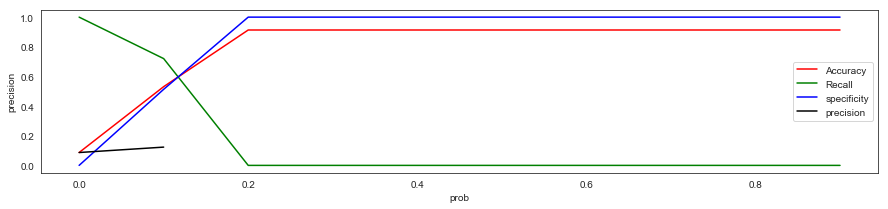

In [115]:
df_pred=predict_with_prob(model_dt_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [116]:
predict_score(model_dt_nor1, y_train, X_train, .04)

Accuracy:	 0.3026134145760937
Recall:  	 0.9473395501919912
Specificity:	 0.2413469557964971
Precision:	 0.10607456544438303
Confusion Matrix:
 [[ 4630 14554]
 [   96  1727]]


In [117]:
predict_score(model_dt_nor1, y_test, X_test, .04)

Accuracy:	 0.29931141714793424
Recall:  	 0.9428571428571428
Specificity:	 0.2391304347826087
Precision:	 0.1038478043198398
Confusion Matrix:
 [[1969 6265]
 [  44  726]]


<font color=red size=3>__Visualize Decision Tree__</font>

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


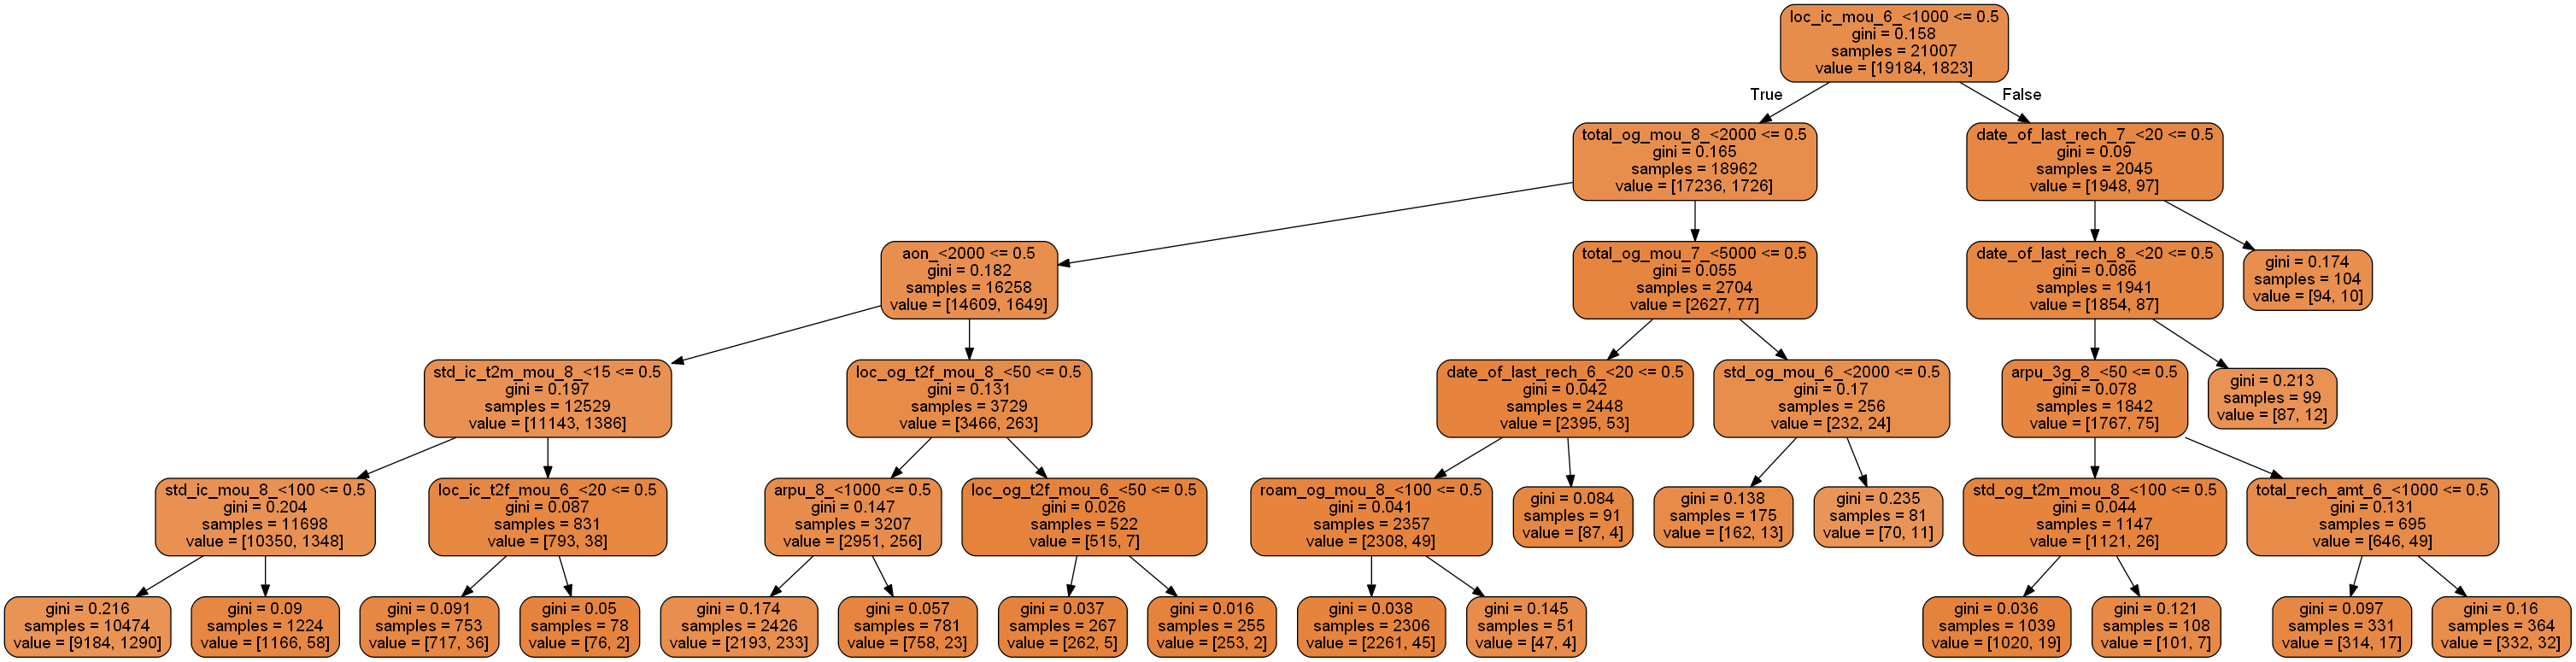

In [118]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
import pydotplus.graphviz
features = list(X_train.columns[0:])
features

# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(model_dt_nor1, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<font color=red size=6>__Final Model__</font>

In [119]:
#Random forest on normal features is giving much better results in terms of recall 
#(the most important metrics of this project) & other metrics. So I am using random forest for final prediction.

#Decsion tree is much better to present to I am using this for presentation purpose.

<font color=red size=6>__Check the Feature Importance__</font>

In [120]:
#Order of feature importance is comming different from Randomforest and DecionTree

In [121]:
df_features = pd.DataFrame({"feature":X_train.columns, "coef":model_rfc_nor1.feature_importances_})
df_features.sort_values("coef", ascending=False)

feature      coef
885       total_ic_mou_8_<500  0.036100
367     loc_og_t2m_mou_8_<500  0.035401
746      std_ic_t2t_mou_8_<10  0.030886
228         loc_ic_mou_8_<500  0.030586
936    total_rech_amt_8_<1000  0.028415
855     std_og_t2t_mou_8_<100  0.028135
131   date_of_last_rech_8_<32  0.023691
203   last_day_rch_amt_8_<200  0.021766
343      loc_og_t2f_mou_8_<10  0.020468
292     loc_ic_t2t_mou_8_<100  0.017492
74               arpu_8_<1000  0.017039
494         offnet_mou_8_<200  0.016913
312         loc_og_mou_8_<500  0.016687
780         std_og_mou_8_<500  0.016438
73                arpu_8_<500  0.015640
495         offnet_mou_8_<500  0.014531
158          ic_others_8_<100  0.014362
389      loc_og_t2t_mou_8_<50  0.013818
293     loc_ic_t2t_mou_8_<500  0.013675
917      total_og_mou_8_<2000  0.013599
272     loc_ic_t2m_mou_8_<500  0.013189
391     loc_og_t2t_mou_8_<500  0.012270
249      loc_ic_t2f_mou_8_<50  0.011942
691      std_ic_t2f_mou_8_<10  0.011930
824     std_og_t2m_mou_8_<100  0.011463
720      std_ic_t2m_mou_8_<50  0.011421
390     loc_og_t2t_mou_8_<100  0.011337
311         loc_og_mou_8_<200  0.010415
637          spl_og_mou_8_<10  0.010035
70                 arpu_8_<50  0.009894
...                       ...       ...
522        onnet_mou_6_<10000  0.000000
529        onnet_mou_7_<10000  0.000000
535         onnet_mou_8_<5000  0.000000
536        onnet_mou_8_<10000  0.000000
538        roam_ic_mou_6_<200  0.000000
539        roam_ic_mou_6_<500  0.000000
540       roam_ic_mou_6_<1000  0.000000
503           og_others_6_<50  0.000000
502           og_others_6_<20  0.000000
501           og_others_6_<10  0.000000
474        night_pck_user_6_1  0.000000
465           monthly_3g_7_<5  0.000000
466          monthly_3g_7_<10  0.000000
467          monthly_3g_7_<20  0.000000
469           monthly_3g_8_<3  0.000000
470           monthly_3g_8_<4  0.000000
471           monthly_3g_8_<5  0.000000
472          monthly_3g_8_<10  0.000000
473          monthly_3g_8_<20  0.000000
475        night_pck_user_7_1  0.000000
500       offnet_mou_8_<20000  0.000000
482        offnet_mou_6_<5000  0.000000
483       offnet_mou_6_<10000  0.000000
484       offnet_mou_6_<20000  0.000000
490        offnet_mou_7_<5000  0.000000
491       offnet_mou_7_<10000  0.000000
492       offnet_mou_7_<20000  0.000000
498        offnet_mou_8_<5000  0.000000
499       offnet_mou_8_<10000  0.000000
1033       vol_3g_mb_8_<50000  0.000000

[1034 rows x 2 columns]

In [122]:
#Those customer which has following attributes has high chances of churning 
#so we need to talk to them and understand their need

df_features.sort_values("coef", ascending=False).feature.head(10)

885        total_ic_mou_8_<500
367      loc_og_t2m_mou_8_<500
746       std_ic_t2t_mou_8_<10
228          loc_ic_mou_8_<500
936     total_rech_amt_8_<1000
855      std_og_t2t_mou_8_<100
131    date_of_last_rech_8_<32
203    last_day_rch_amt_8_<200
343       loc_og_t2f_mou_8_<10
292      loc_ic_t2t_mou_8_<100
Name: feature, dtype: object

In [123]:
#date_of_last_rech_8_<32 means date_of_last_rech_8 th month between 25 & 31